# VAR inference on a Real Public Dataset, Herold et al. (2020)

In this example, we will be using the GP imputator on a dataset available at [Herold et al., 2020](https://doi.org/10.1038/s41467-020-19006-2) to imputate missing data. Then, we are going to use the VAR inference method to infer the causal relationships between the variables in the time series. 

First, we will import the neccessary libraries and load the dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns


from mimic.data_imputation.impute_GP import GPImputer
from mimic.model_infer.infer_VAR_bayes import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv(r'Source Data/fig3ab.tsv', delimiter='\t')

data.head(15)

genus        date       val type
0   Acidimicrobium  2011-03-21  8.322484   MG
1   Acidimicrobium  2011-03-29  7.664534   MG
2   Acidimicrobium  2011-04-05  7.871188   MG
3   Acidimicrobium  2011-04-14  6.695900   MG
4   Acidimicrobium  2011-04-21  6.695177   MG
5   Acidimicrobium  2011-04-29  6.304652   MG
6   Acidimicrobium  2011-05-06  7.462918   MG
7   Acidimicrobium  2011-05-13  7.742366   MG
8   Acidimicrobium  2011-05-20  6.627358   MG
9   Acidimicrobium  2011-05-27  7.425880   MG
10  Acidimicrobium  2011-06-03  7.890684   MG
11  Acidimicrobium  2011-06-09  6.306718   MG
12  Acidimicrobium  2011-06-17  6.607237   MG
13  Acidimicrobium  2011-06-24  8.888402   MG
14  Acidimicrobium  2011-07-01  9.086751   MG

# Separate the data into MG and MT datasets

The data is separated into two datasets, MG and MT. The MG dataset contains the meta-genomics data, while the MT dataset contains the meta-transcriptomics. We will be using the MG dataset in this example.


In [3]:
# separate the data into MG and MT datasets

dataMG = data[data['type'] == 'MG']

dataMG.info()

dataMT = data[data['type'] == 'MT']

dataMT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 611
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   genus   561 non-null    object 
 1   date    612 non-null    object 
 2   val     612 non-null    float64
 3   type    612 non-null    object 
dtypes: float64(1), object(3)
memory usage: 23.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 561 entries, 612 to 1172
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   genus   510 non-null    object 
 1   date    561 non-null    object 
 2   val     561 non-null    float64
 3   type    561 non-null    object 
dtypes: float64(1), object(3)
memory usage: 21.9+ KB


We will proceed with some data wrangling to prepare the data for the imputation process.

In [4]:
# Data cleaning
# Rename Nan in the genus column to 'Other'

dataMG['genus'] = dataMG['genus'].replace(np.nan, 'Other')

# Drop the 'type' column
dataMG = dataMG.drop(columns=['type'])

# Change relative Date columns to days
dataMG['date'] = pd.to_datetime(dataMG['date'])
dataMG['date'] = (dataMG['date'] - dataMG['date'].min()).dt.days

# Change the 'genus' column to a categorical column
dataMG['genus'] = dataMG['genus'].astype('category')


dataMG.info()

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 611
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   genus   612 non-null    category
 1   date    612 non-null    int64   
 2   val     612 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 15.3 KB


C:\Users\User\AppData\Local\Temp\ipykernel_27368\1446871442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMG['genus'] = dataMG['genus'].replace(np.nan, 'Other')


c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


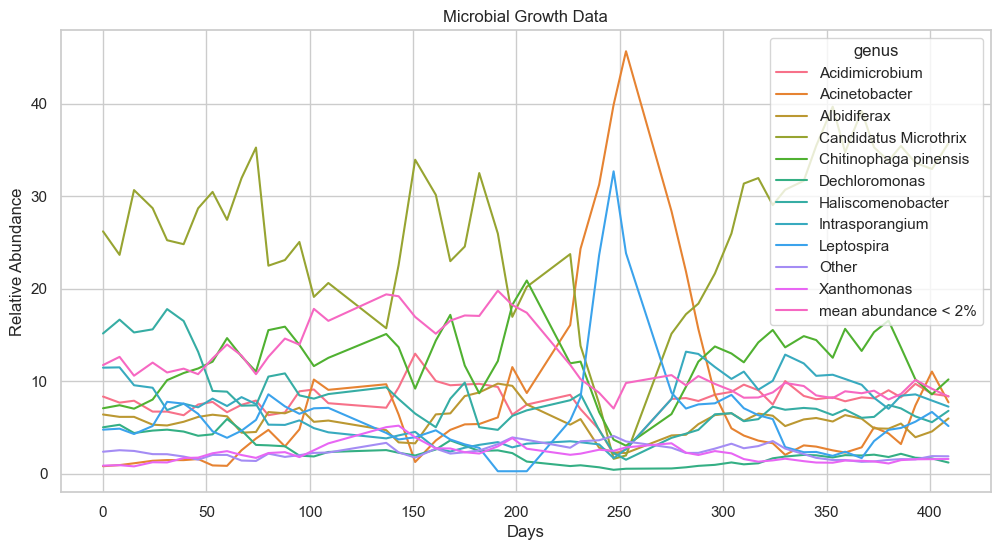

In [5]:
# Plot the data, relative abundance (value) vs. days (date) for each genus


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='val', hue='genus', data=dataMG)
plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.show()

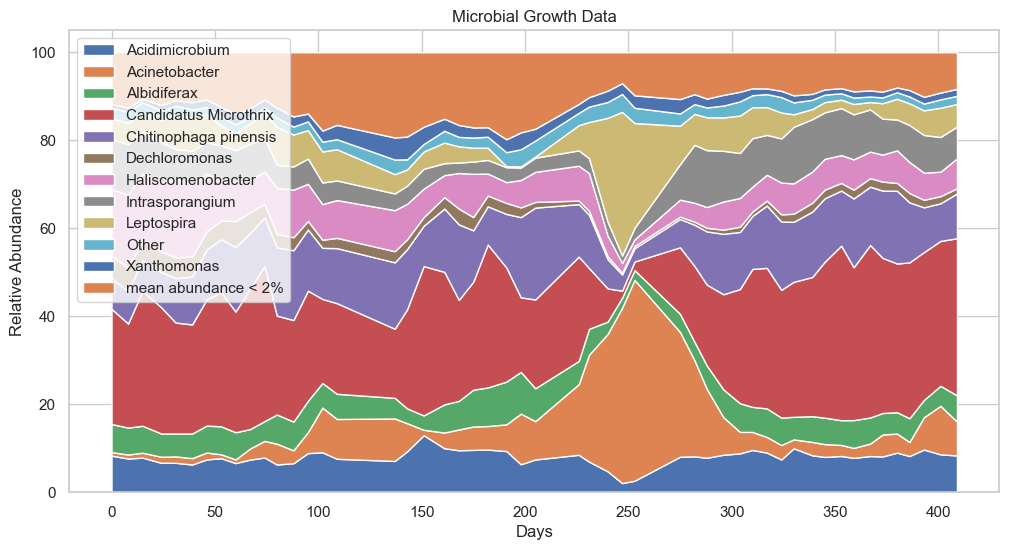

In [6]:
# Pivot the data so each 'genus' is a column
dataMG_pivot = dataMG.pivot(
    index='date', columns='genus', values='val').fillna(0)

# Create a stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(dataMG_pivot.index, dataMG_pivot.T, labels=dataMG_pivot.columns)

plt.title('Microbial Growth Data')
plt.xlabel('Days')
plt.ylabel('Relative Abundance')
plt.legend(loc='upper left')

plt.show()

In [7]:

# Create a DataFrame with a complete range of days
all_days = pd.DataFrame(
    {'days': range(dataMG['date'].min(), dataMG['date'].max() + 1)})

# Reindex the pivoted DataFrame to include all days, filling missing values with None
complete_dataMG = dataMG_pivot.reindex(all_days['days'])

complete_dataMG.head(15)

genus  Acidimicrobium  Acinetobacter  Albidiferax  Candidatus Microthrix  \
days                                                                       
0            8.322484       0.791870     6.383491              26.180838   
1                 NaN            NaN          NaN                    NaN   
2                 NaN            NaN          NaN                    NaN   
3                 NaN            NaN          NaN                    NaN   
4                 NaN            NaN          NaN                    NaN   
5                 NaN            NaN          NaN                    NaN   
6                 NaN            NaN          NaN                    NaN   
7                 NaN            NaN          NaN                    NaN   
8            7.664534       0.911291     6.125822              23.641355   
9                 NaN            NaN          NaN                    NaN   
10                NaN            NaN          NaN                    NaN   
11                NaN            NaN          NaN                    NaN   
12                NaN            NaN          NaN                    NaN   
13                NaN            NaN          NaN                    NaN   
14                NaN            NaN          NaN                    NaN   

genus  Chitinophaga pinensis  Dechloromonas  Haliscomenobacter  \
days                                                             
0                   7.055585       4.998287          15.142620   
1                        NaN            NaN                NaN   
2                        NaN            NaN                NaN   
3                        NaN            NaN                NaN   
4                        NaN            NaN                NaN   
5                        NaN            NaN                NaN   
6                        NaN            NaN                NaN   
7                        NaN            NaN                NaN   
8                   7.383681       5.273044          16.636265   
9                        NaN            NaN                NaN   
10                       NaN            NaN                NaN   
11                       NaN            NaN                NaN   
12                       NaN            NaN                NaN   
13                       NaN            NaN                NaN   
14                       NaN            NaN                NaN   

genus  Intrasporangium  Leptospira     Other  Xanthomonas  mean abundance < 2%  
days                                                                            
0            11.445072    4.742982  2.357318     0.853658            11.725795  
1                  NaN         NaN       NaN          NaN                  NaN  
2                  NaN         NaN       NaN          NaN                  NaN  
3                  NaN         NaN       NaN          NaN                  NaN  
4                  NaN         NaN       NaN          NaN                  NaN  
5                  NaN         NaN       NaN          NaN                  NaN  
6                  NaN         NaN       NaN          NaN                  NaN  
7                  NaN         NaN       NaN          NaN                  NaN  
8            11.476739    4.850959  2.520630     0.903478            12.612201  
9                  NaN         NaN       NaN          NaN                  NaN  
10                 NaN         NaN       NaN          NaN                  NaN  
11                 NaN         NaN       NaN          NaN                  NaN  
12                 NaN         NaN       NaN          NaN                  NaN  
13                 NaN         NaN       NaN          NaN                  NaN  
14                 NaN         NaN       NaN          NaN                  NaN

In [8]:
complete_dataMG.columns

CategoricalIndex(['Acidimicrobium', 'Acinetobacter', 'Albidiferax',
                  'Candidatus Microthrix', 'Chitinophaga pinensis',
                  'Dechloromonas', 'Haliscomenobacter', 'Intrasporangium',
                  'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'],
                 categories=['Acidimicrobium', 'Acinetobacter', 'Albidiferax', 'Candidatus Microthrix', ..., 'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'], ordered=False, dtype='category', name='genus')

If we pick one column, say 'Acinetobacter', we can see that there are missing values in the dataset. We will use the GP imputator to fill in the missing values.

In [9]:
complete_dataMG['Acinetobacter'].isnull().sum()

359

In [10]:
# Reset the index
complete_dataMG_reset = complete_dataMG.reset_index()

# Make index as float
complete_dataMG_reset['days'] = complete_dataMG_reset['days'].astype(float)

Model: VGP
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: 236147.03324540867


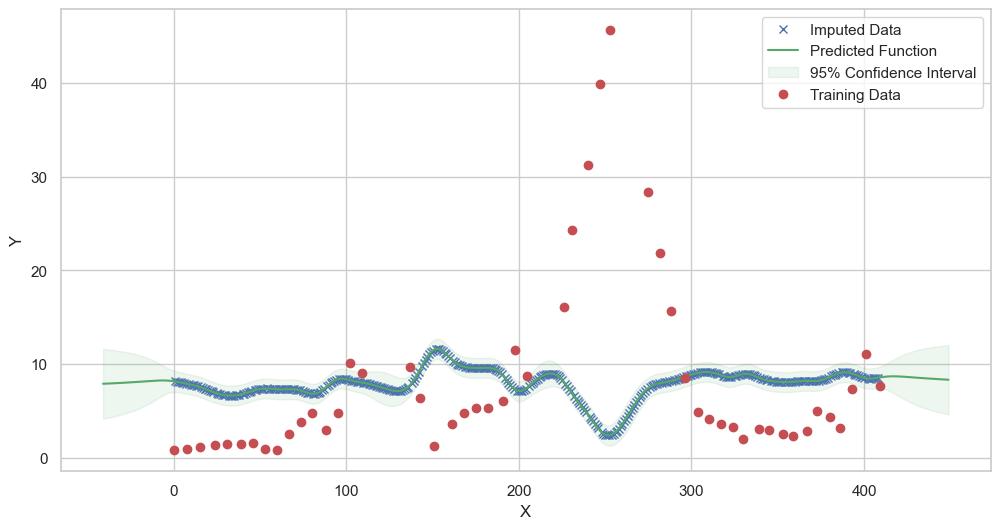

In [11]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium',
                                      'Acinetobacter', 'Albidiferax'], 'Acinetobacter'
)

In [12]:
new_dataset['Acinetobacter'].isnull().sum()

0

We can see now that the data imputator calculated the missing values for the 'Acinetobacter' column. However, as we can see fro the graph, the imputed values are not great. This can be caused by multiple factors, so we are going to explore different methods to better impute the missing values. 

We are first going to try to do imputation using VGP imputation. This is a variational Gaussian process imputation method that is more robust to missing data and uses multiple imputs to calculate the missing values. However, as we will see, this method creates an imputation that is heavily biased by other imputs, so it doesn't work in our case to determine the missing values of the 'Acinetobacter' column.

Model: VGP
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: 4811115.618247565


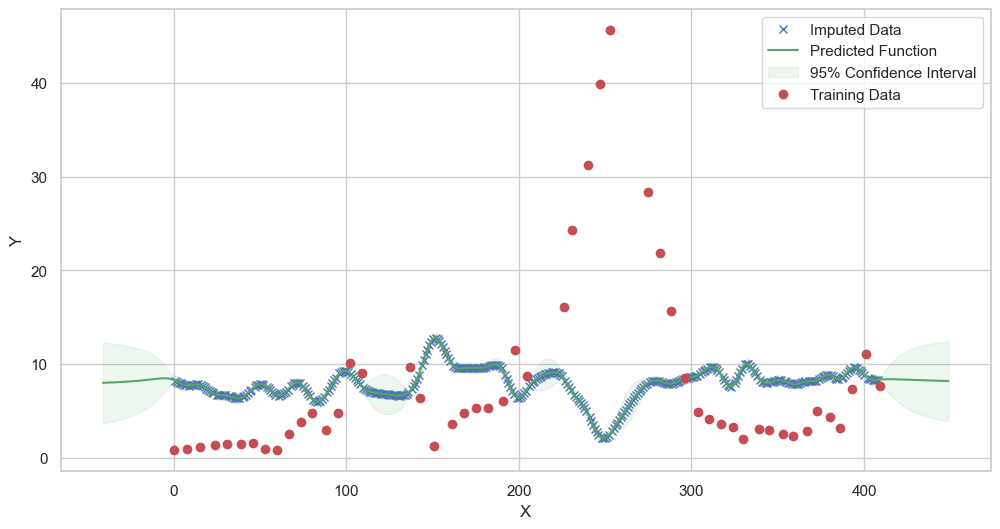

In [13]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acidimicrobium', 'Acinetobacter', 'Albidiferax',
                                      'Candidatus Microthrix', 'Chitinophaga pinensis',
                                      'Dechloromonas', 'Haliscomenobacter', 'Intrasporangium',
                                      'Leptospira', 'Other', 'Xanthomonas', 'mean abundance < 2%'], 'Acinetobacter'
)

If we, isntead, do a single imputation using only a GPR model with a single imput ('Acinetobacter'), we can see that the imputation is much better. This is because the imputation is not biased by other imputs, and the model can better predict the missing values.

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -248.40300696649717


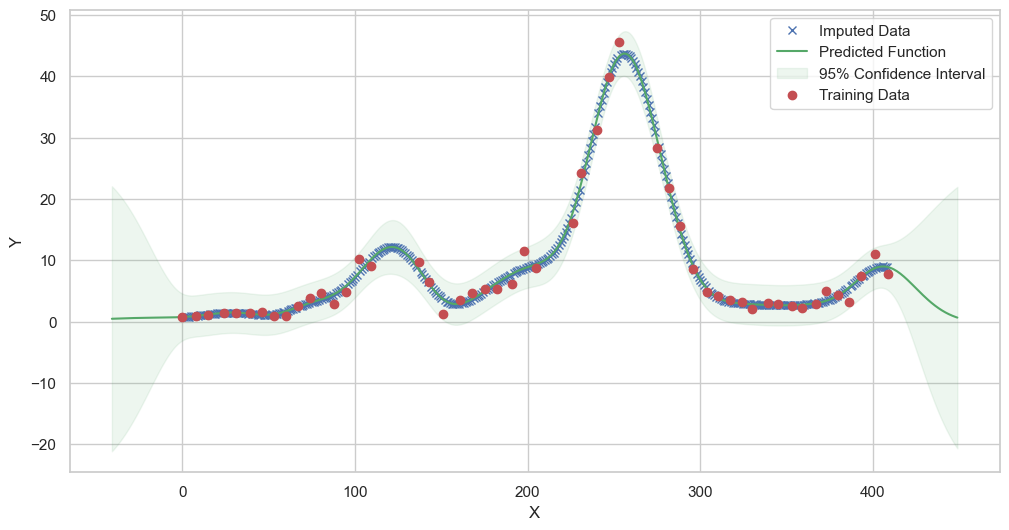

In [14]:
# Now 'days' is a regular column and you can use it as a feature
new_dataset2 = GPImputer().impute_missing_values(
    complete_dataMG_reset, ['days'], ['Acinetobacter'], 'Acinetobacter'
)

In [15]:
# Save the dataset (new_dataset2) to a csv file
new_dataset2.to_csv(r'imputed_data.csv', index=False)

So we will proceed to do a single imput GPR model for all the columns in the dataset. We will then use the VAR inference method to infer the causal relationships between the variables in the time series.

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -162.28151984461607


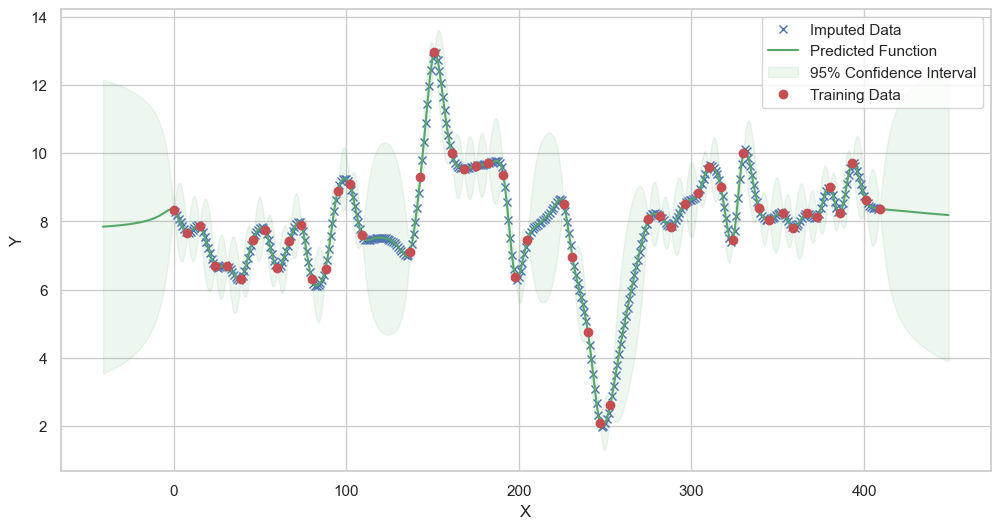

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -248.40300696649717


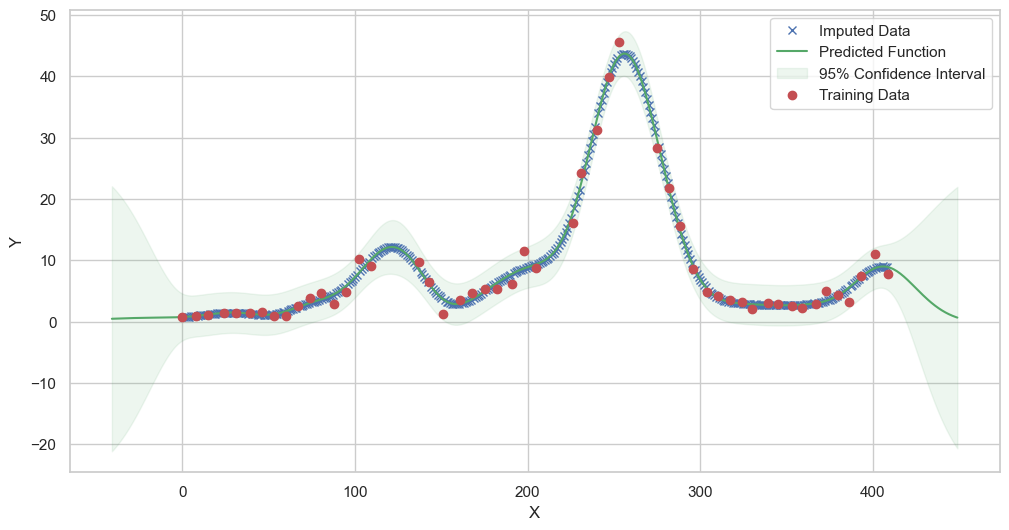

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -137.06584629672068


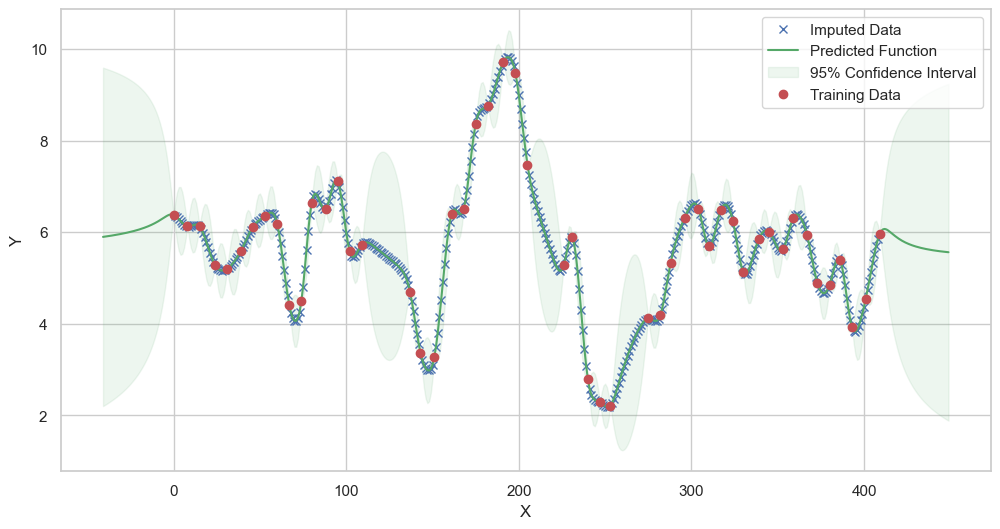

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -297.92365659240966


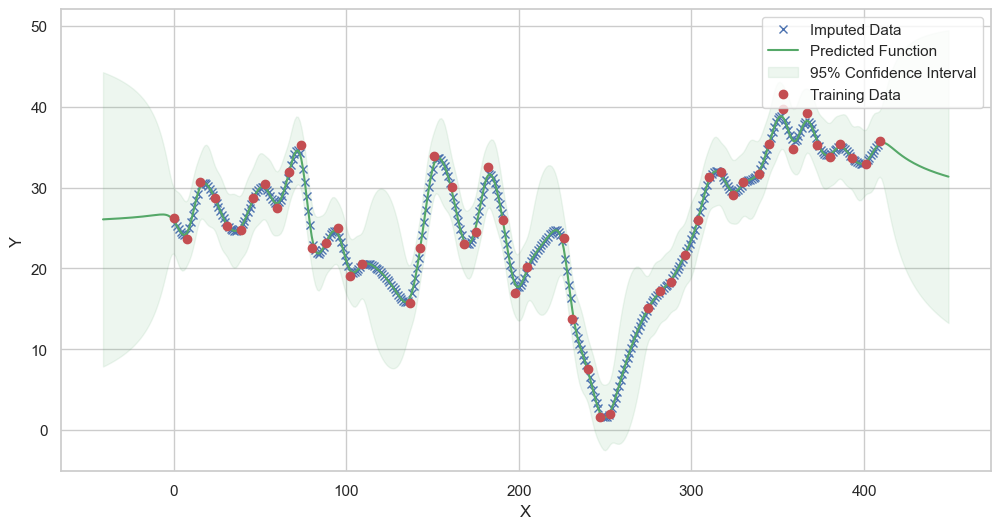

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -225.68501007391774


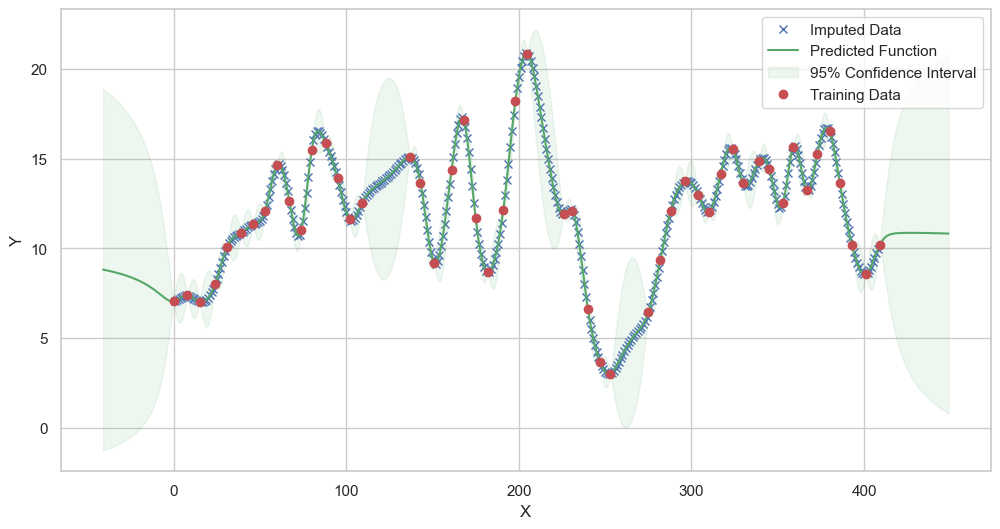

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -71.0838410931403


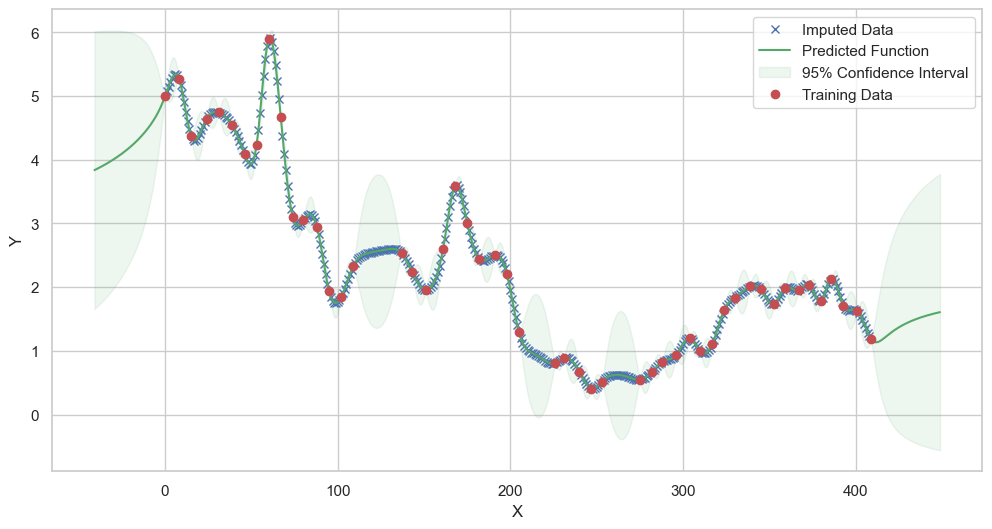

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -181.18602198312468


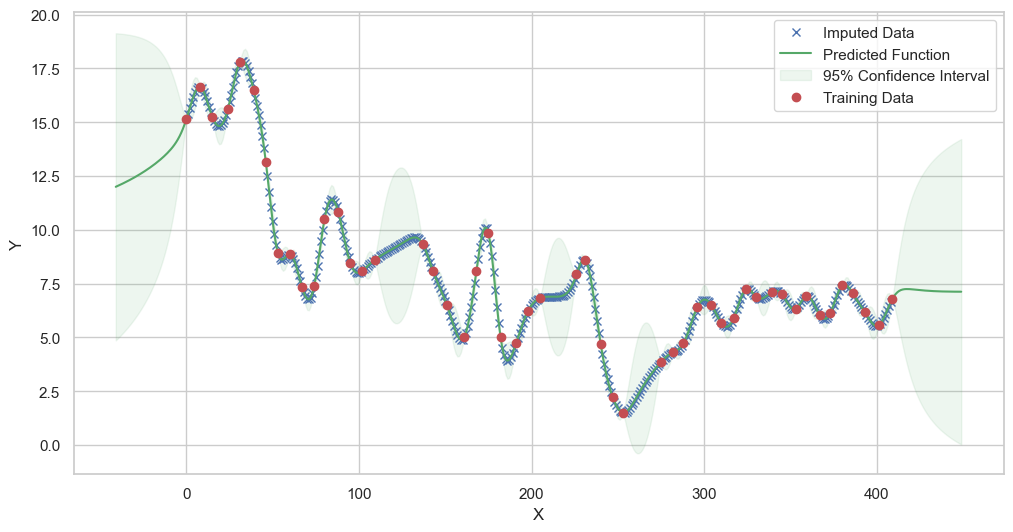

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -168.5312326022697


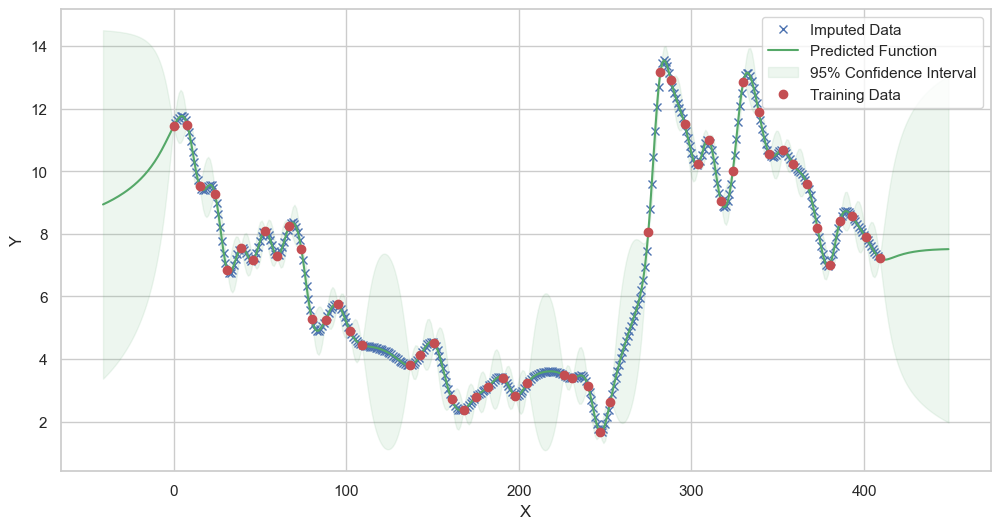

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -236.7104662129815


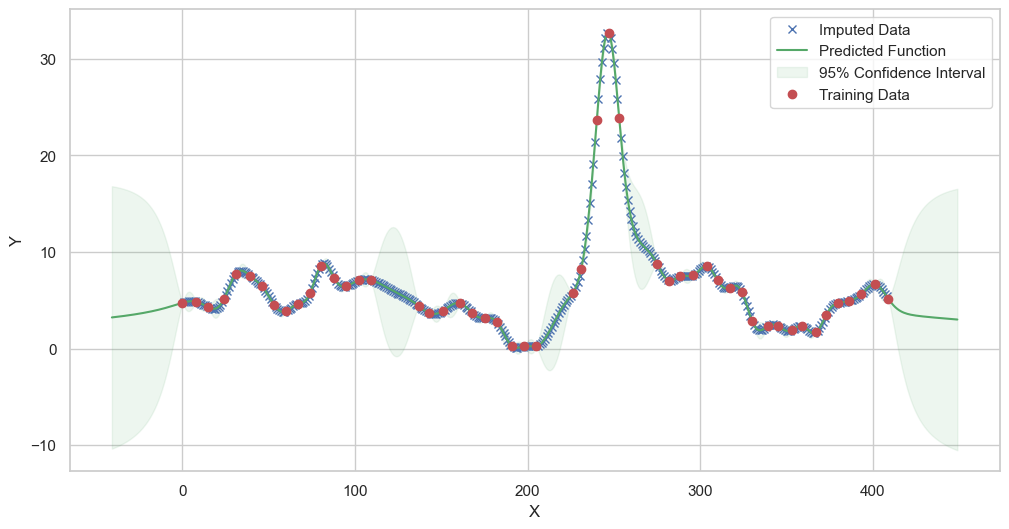

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -51.797015513175154


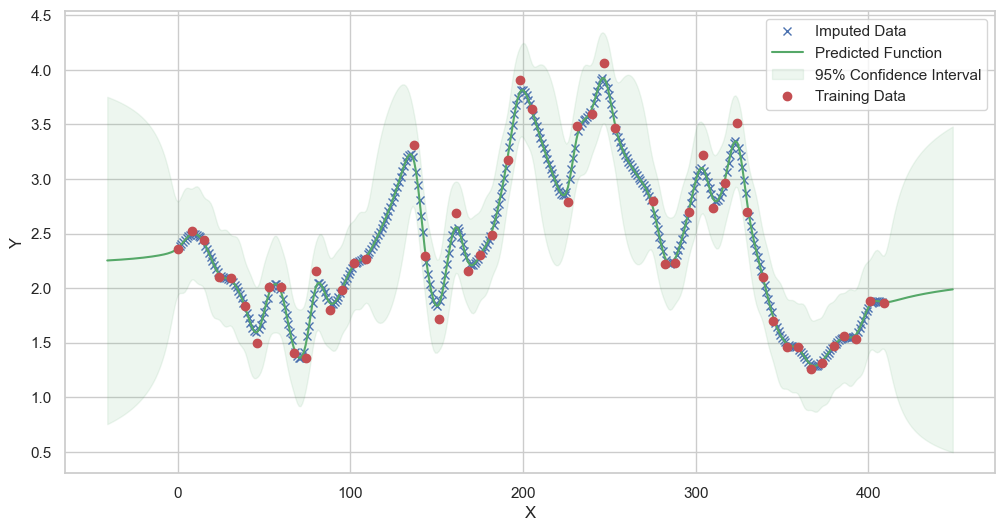

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.RationalQuadratic'>
BIC: -54.937802829878464


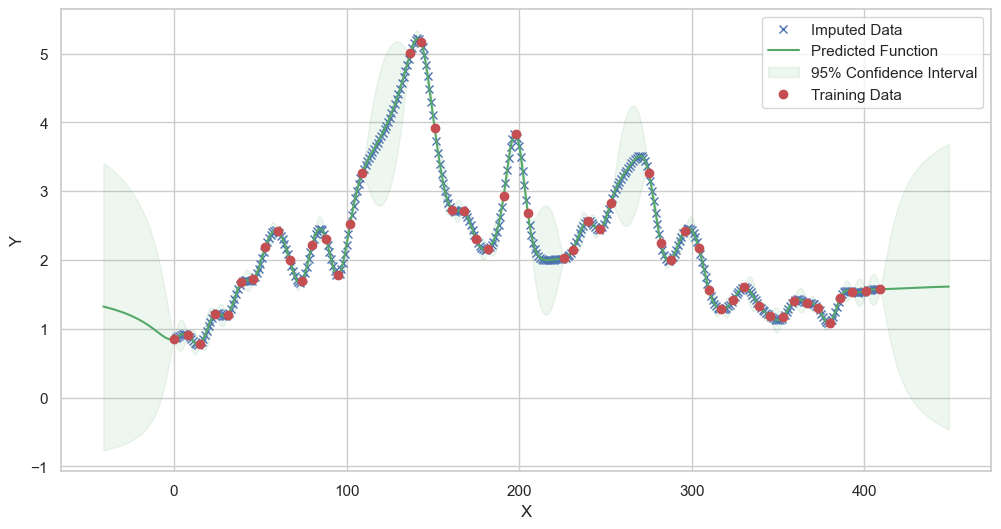

Model: GPR
Best kernel: <class 'gpflow.kernels.stationaries.Exponential'>
BIC: -178.35294381418785


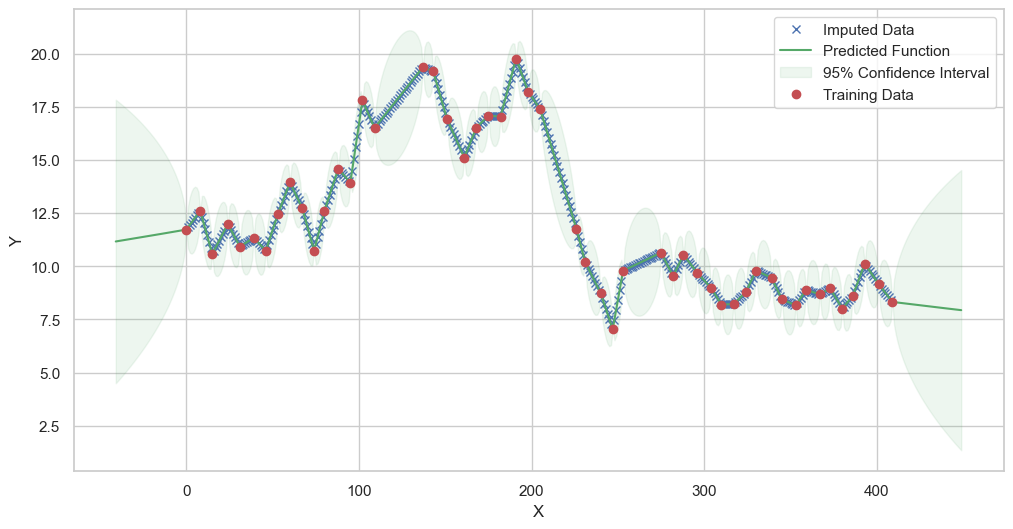

In [16]:
# do the imputation for each column (genus) in the dataset
# Copy the original dataset
new_dataset_complete = complete_dataMG_reset.copy()

for genus in complete_dataMG.columns:
    # Impute the missing values for the current column
    imputed_data = GPImputer().impute_missing_values(
        complete_dataMG_reset, ['days'], [genus], genus
    )

    # Update the column in the new dataset with the imputed data
    new_dataset_complete[genus] = imputed_data[genus]

# Save the dataset (new_dataset_complete) to a csv file
new_dataset_complete.to_csv('imputed_data.csv', index=False)

In [17]:
# Reload the imputed data into a new DataFrame

imputed_data = pd.read_csv('imputed_data.csv')

imputed_data.head(15)

days  Acidimicrobium  Acinetobacter  Albidiferax  Candidatus Microthrix  \
0    0.0        8.322484       0.791870     6.383491              26.180838   
1    1.0        8.265177       0.763703     6.362575              25.593890   
2    2.0        8.180701       0.781881     6.330330              25.226861   
3    3.0        8.078737       0.801890     6.290243              24.849371   
4    4.0        7.969807       0.823758     6.246734              24.505012   
5    5.0        7.863614       0.847488     6.204391              24.245813   
6    6.0        7.770084       0.873055     6.167656              24.127242   
7    7.0        7.700314       0.900405     6.140528              24.199845   
8    8.0        7.664534       0.911291     6.125822              23.641355   
9    9.0        7.666801       0.960073     6.124129              25.024940   
10  10.0        7.701597       0.992116     6.133189              25.753165   
11  11.0        7.756540       1.025393     6.148177              26.621835   
12  12.0        7.816900       1.059680     6.162504              27.550701   
13  13.0        7.867041       1.094721     6.168573              28.452806   
14  14.0        7.890203       1.130229     6.158709              29.247651   

    Chitinophaga pinensis  Dechloromonas  Haliscomenobacter  Intrasporangium  \
0                7.055585       4.998287          15.142620        11.445072   
1                7.081694       5.072711          15.397948        11.546582   
2                7.127157       5.147886          15.663537        11.636934   
3                7.185821       5.219273          15.926969        11.710476   
4                7.249498       5.280679          16.172482        11.759176   
5                7.309111       5.324508          16.382314        11.772278   
6                7.355842       5.342460          16.538718        11.737040   
7                7.382293       5.326927          16.626579        11.641157   
8                7.383681       5.273044          16.636265        11.476739   
9                7.358852       5.180566          16.565955        11.244474   
10               7.310707       5.055128          16.422573        10.955857   
11               7.245802       4.907436          16.220878        10.632238   
12               7.173270       4.751605          15.981051        10.301403   
13               7.103389       4.602845          15.725567         9.993155   
14               7.046066       4.475146          15.476159         9.734647   

    Leptospira     Other  Xanthomonas  mean abundance < 2%  
0     4.742982  2.357318     0.853658            11.725795  
1     4.791269  2.382206     0.864697            11.836536  
2     4.833619  2.399779     0.879132            11.947293  
3     4.868031  2.418784     0.894873            12.058067  
4     4.892380  2.438263     0.909303            12.168858  
5     4.904550  2.457029     0.919595            12.279667  
6     4.902619  2.473734     0.923138            12.390494  
7     4.885061  2.487002     0.918012            12.501338  
8     4.850959  2.520630     0.903478            12.612201  
9     4.800196  2.499159     0.880339            12.321359  
10    4.733611  2.497398     0.851104            12.030537  
11    4.653122  2.490776     0.819790            11.739731  
12    4.561808  2.479674     0.791448            11.448942  
13    4.463977  2.464200     0.771427            11.158170  
14    4.365213  2.444171     0.764505            10.867413

And we can run the VAR inference method to infer the causal relationships between the variables in the time series.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x0, A, noise_chol]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2168 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x0[0]      1.000  0.000   1.000    1.000      0.000    0.000       3.0   
x0[1]      0.040  0.351  -0.311    0.392      0.248    0.210       3.0   
x0[2]      0.189  0.139   0.050    0.328      0.098    0.083       3.0   
x0[3]      0.854  0.051   0.803    0.904      0.036    0.030       3.0   
x0[4]      0.450  0.473  -0.023    0.923      0.334    0.283       2.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[12, 8]  -0.167  0.128  -0.294   -0.039      0.090    0.076       3.0   
A[12, 9]  -0.030  0.038  -0.069    0.008      0.027    0.023       2.0   
A[12, 10]  0.105  0.729  -0.624    0.834      0.515    0.436       3.0   
A[12, 11] -1.459  1.413  -2.873   -0.046      0.997    0.845       2.0   
A[12, 12]  0.814  0.081   0.733    0.895      0.057    0.049       3.0   

           ess_tail  r_hat  
x0[0]          23.0   2.22  
x0[1]          21.0   2.01  
x0[2]          13.0   2.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (182) in plot_posterior, generating only 40 plots
  warnings.warn(


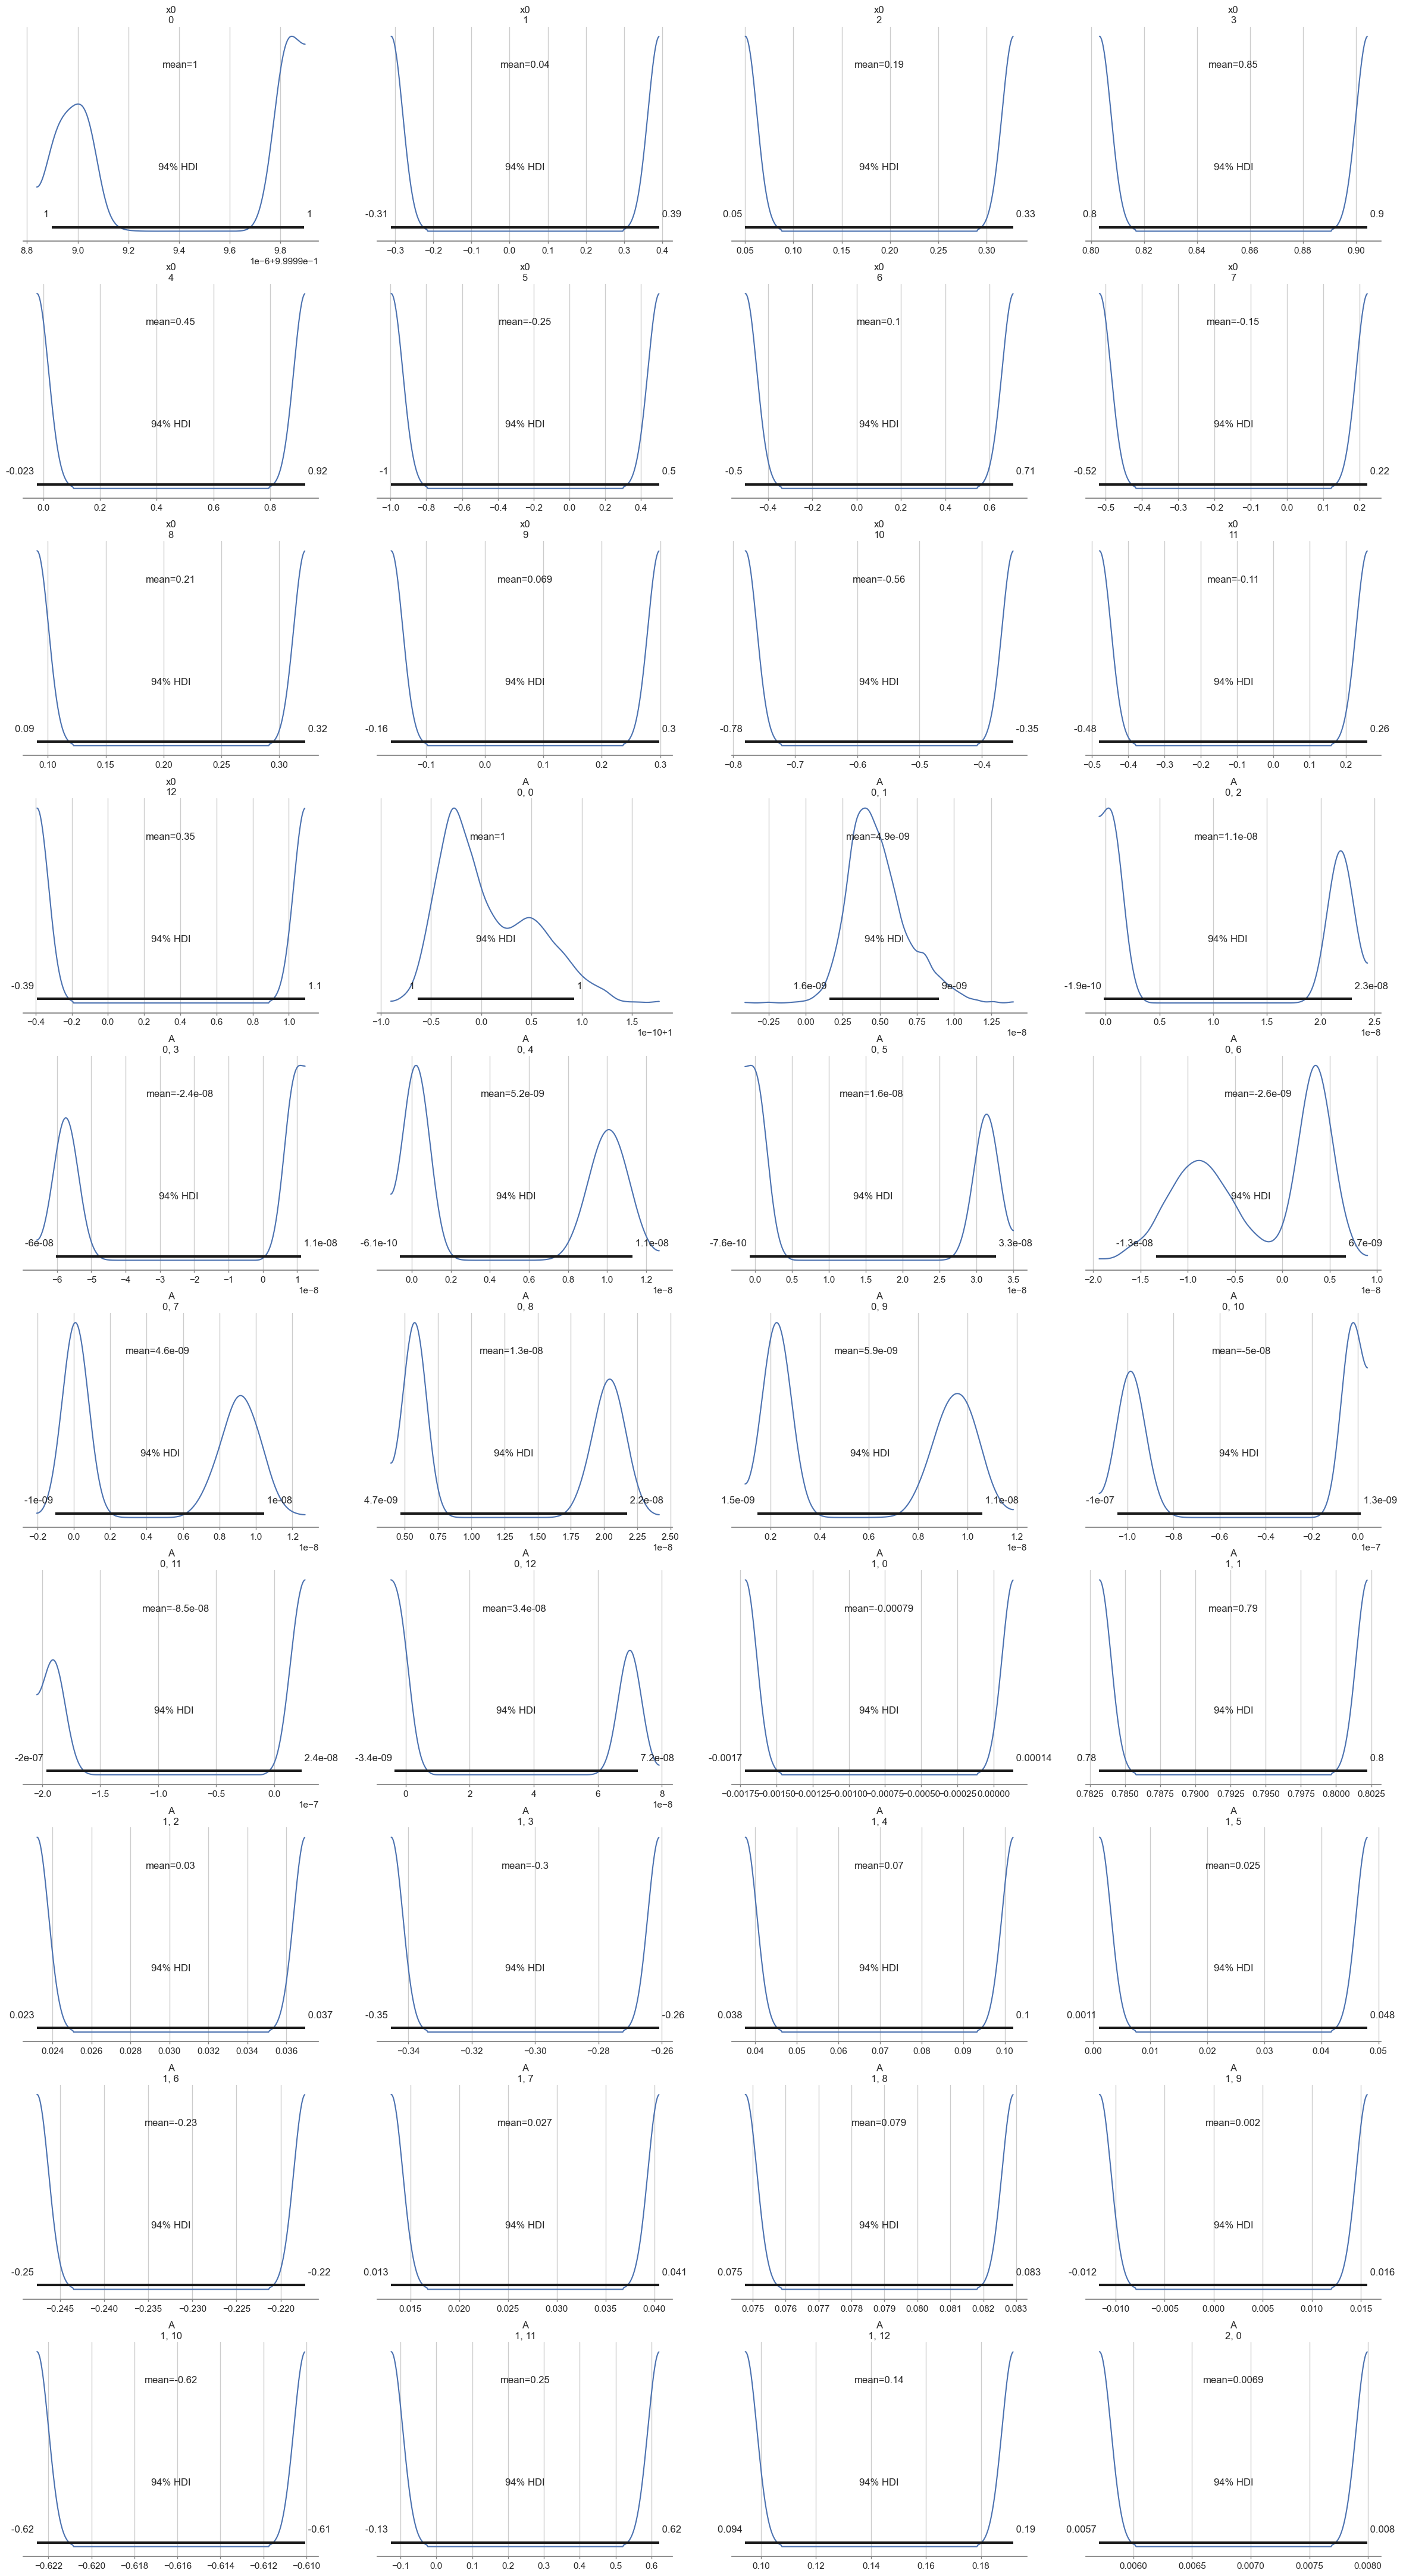

In [18]:
infer = infer_VAR(imputed_data)
infer.run_inference()

However, since the results are not great, we can try running run_inference_large() which uses parameter shrinkage and other prior assumptions to try and improve the inference results.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 2254 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3325 divergences after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    1.000  0.000   1.000    1.000        0.0      0.0    1310.0   
A[0, 1]    0.011  0.001   0.009    0.012        0.0      0.0    3280.0   
A[0, 2]    0.010  0.000   0.010    0.011        0.0      0.0    1047.0   
A[0, 3]    0.008  0.001   0.007    0.010        0.0      0.0    4577.0   
A[0, 4]    0.010  0.000   0.010    0.011        0.0      0.0    2265.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[12, 8]   0.005  0.004  -0.002    0.013        0.0      0.0     363.0   
A[12, 9]   0.015  0.003   0.010    0.020        0.0      0.0     803.0   
A[12, 10] -0.100  0.019  -0.135   -0.063        0.0      0.0    2057.0   
A[12, 11]  0.004  0.011  -0.018    0.028        0.0      0.0    3054.0   
A[12, 12]  1.009  0.006   0.998    1.020        0.0      0.0     639.0   

           ess_tail  r_hat  
A[0, 0]      4371.0   1.01  
A[0, 1]      5214.0   1.00  
A[0, 2]       752.0   1.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (169) in plot_posterior, generating only 40 plots
  warnings.warn(


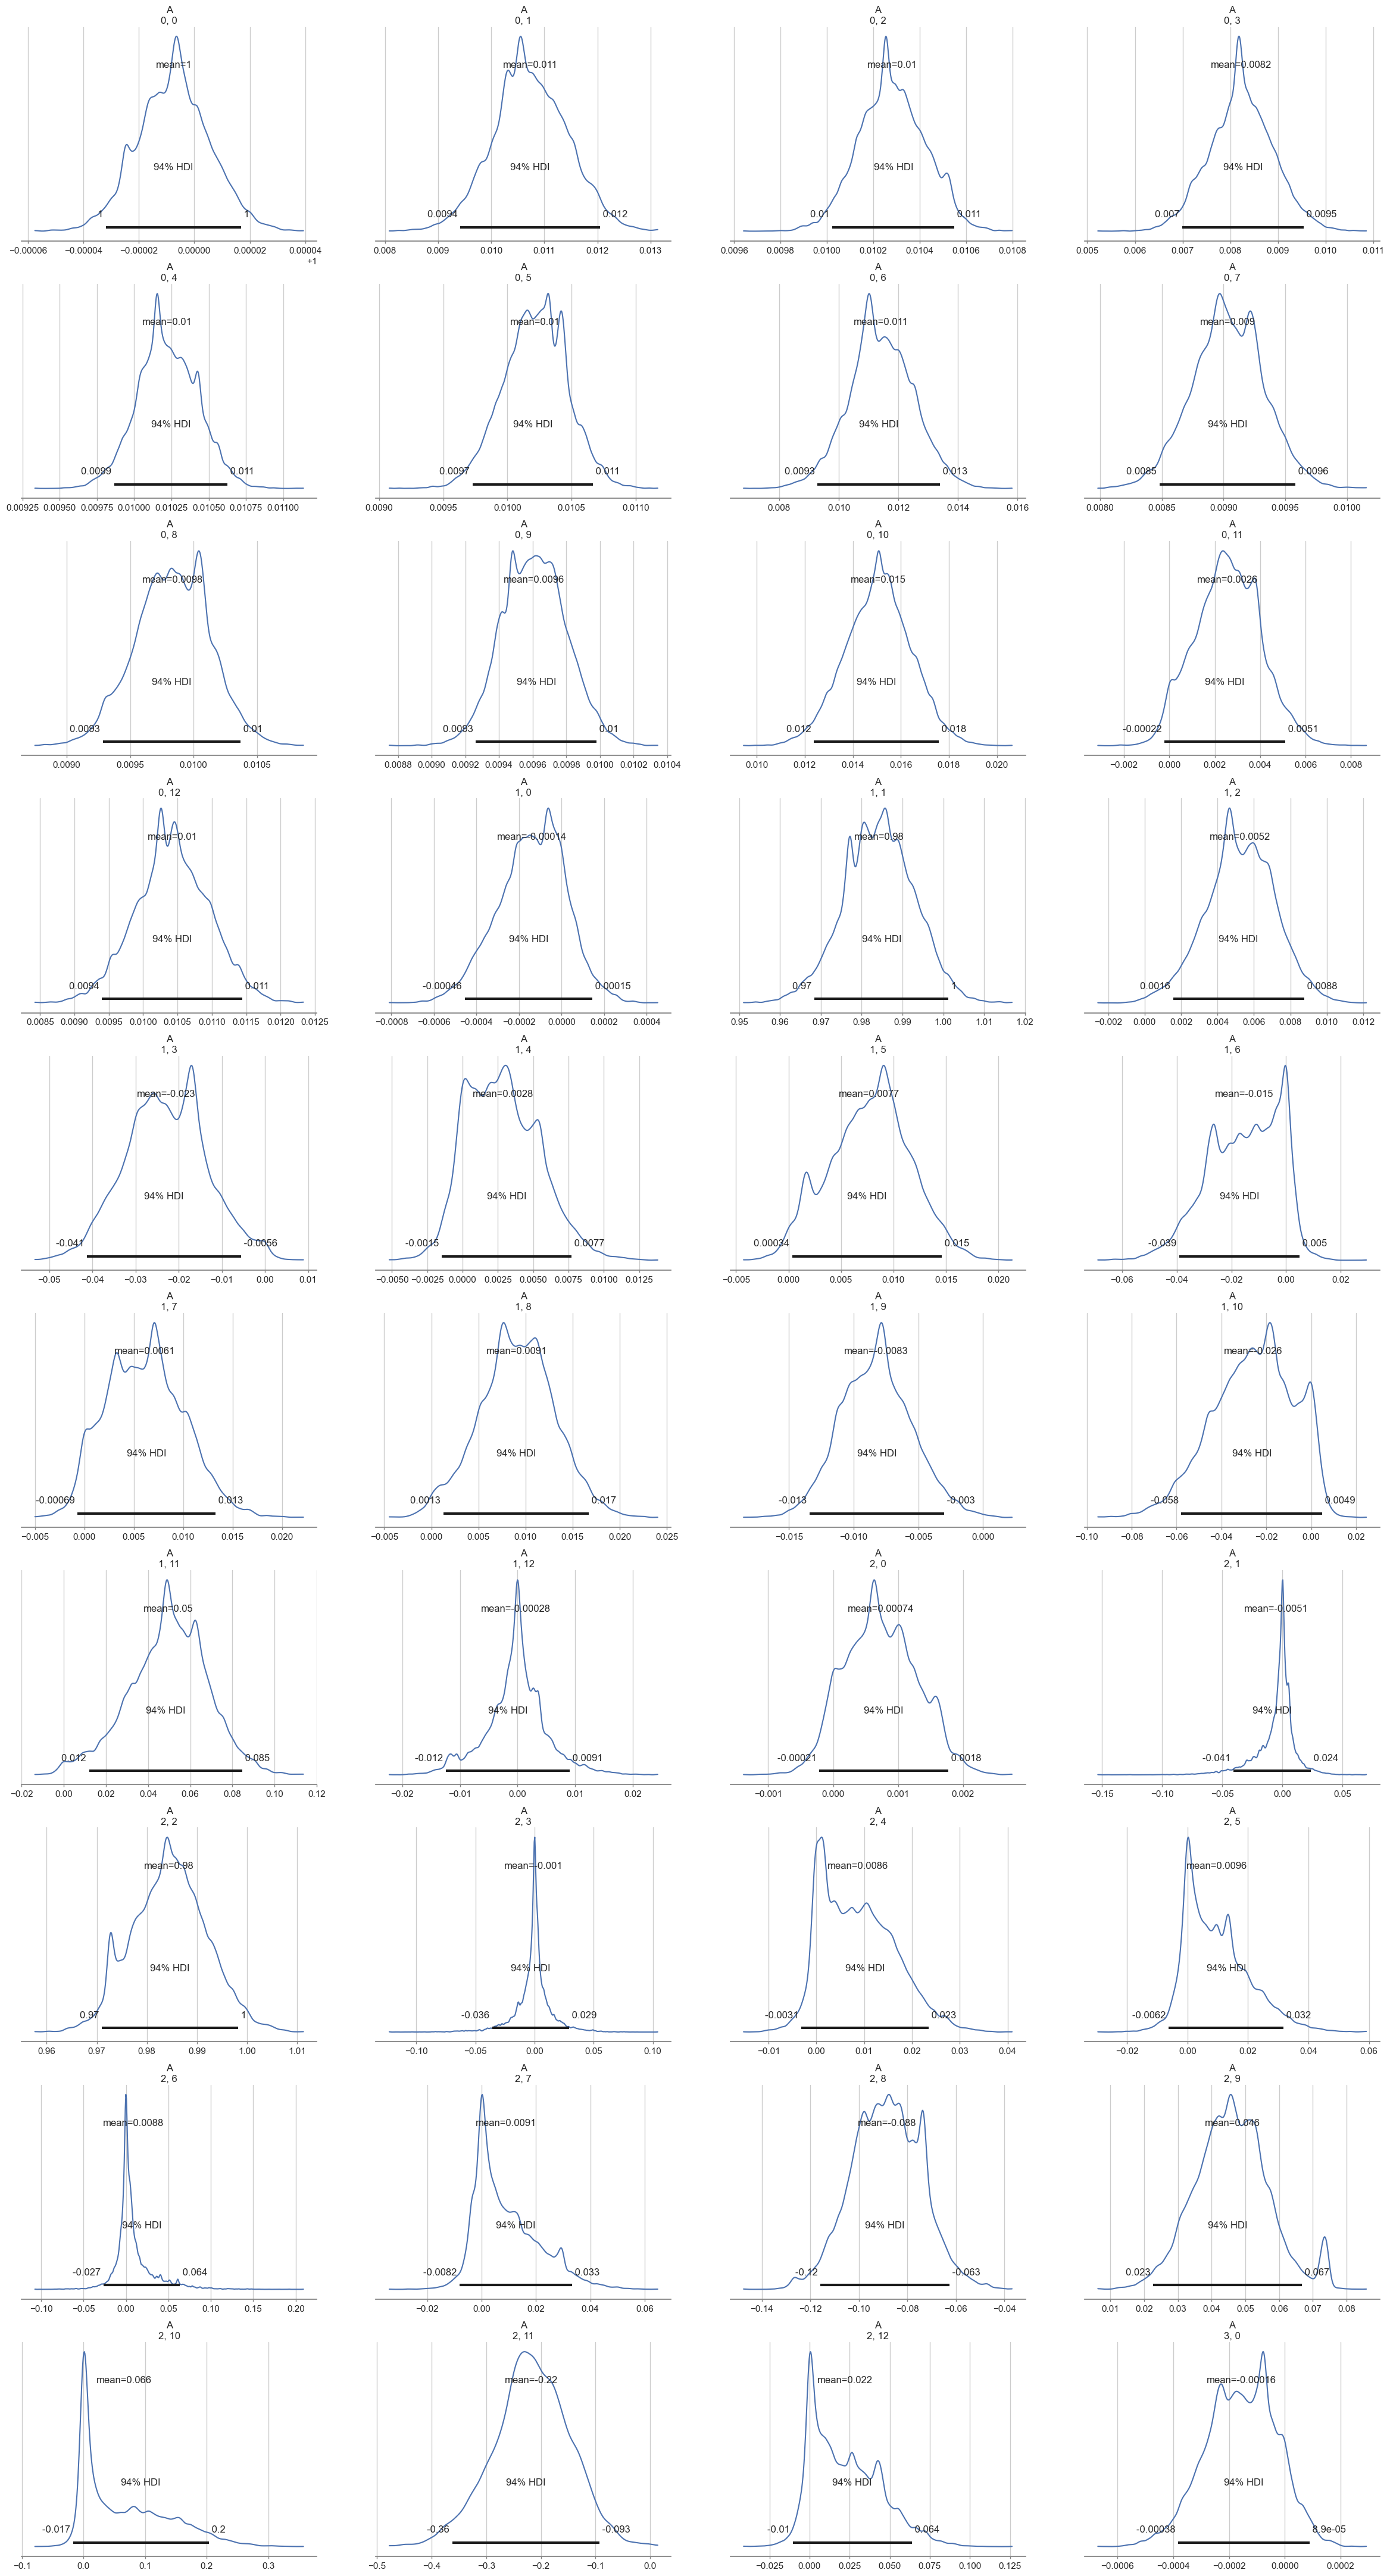

In [19]:
infer = infer_VAR(imputed_data)
infer.run_inference_large()

The results show an improvement (as seen by the r_hat values). However, if we look at the posterior distributions, some of them are wide, others are skewed, and some are multimodal. This indicates that the model is not a good fit for the data. Therefore, we are going to try different methods to improve the inference results.

First of all, we are going to see if we normalize the data, if the inference results improve. We can see that the results even worse than before. This is because the data is already normalized, so normalizing it again is not a good idea.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 7075 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    1.000  0.000   1.000    1.000      0.000    0.000       5.0   
A[0, 1]    0.000  0.000   0.000    0.000      0.000    0.000       5.0   
A[0, 2]    0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
A[0, 3]   -0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
A[0, 4]    0.000  0.000  -0.000    0.000      0.000    0.000       5.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[12, 8]  -0.236  0.294  -0.630    0.197      0.147    0.113       4.0   
A[12, 9]  -0.091  0.266  -0.326    0.345      0.133    0.102       4.0   
A[12, 10]  0.032  0.137  -0.108    0.229      0.068    0.052       4.0   
A[12, 11]  0.360  0.170   0.110    0.591      0.085    0.065       4.0   
A[12, 12]  0.235  0.313  -0.198    0.570      0.156    0.120       4.0   

           ess_tail  r_hat  
A[0, 0]        26.0   2.84  
A[0, 1]        26.0   2.59  
A[0, 2]        26.0   2.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (169) in plot_posterior, generating only 40 plots
  warnings.warn(


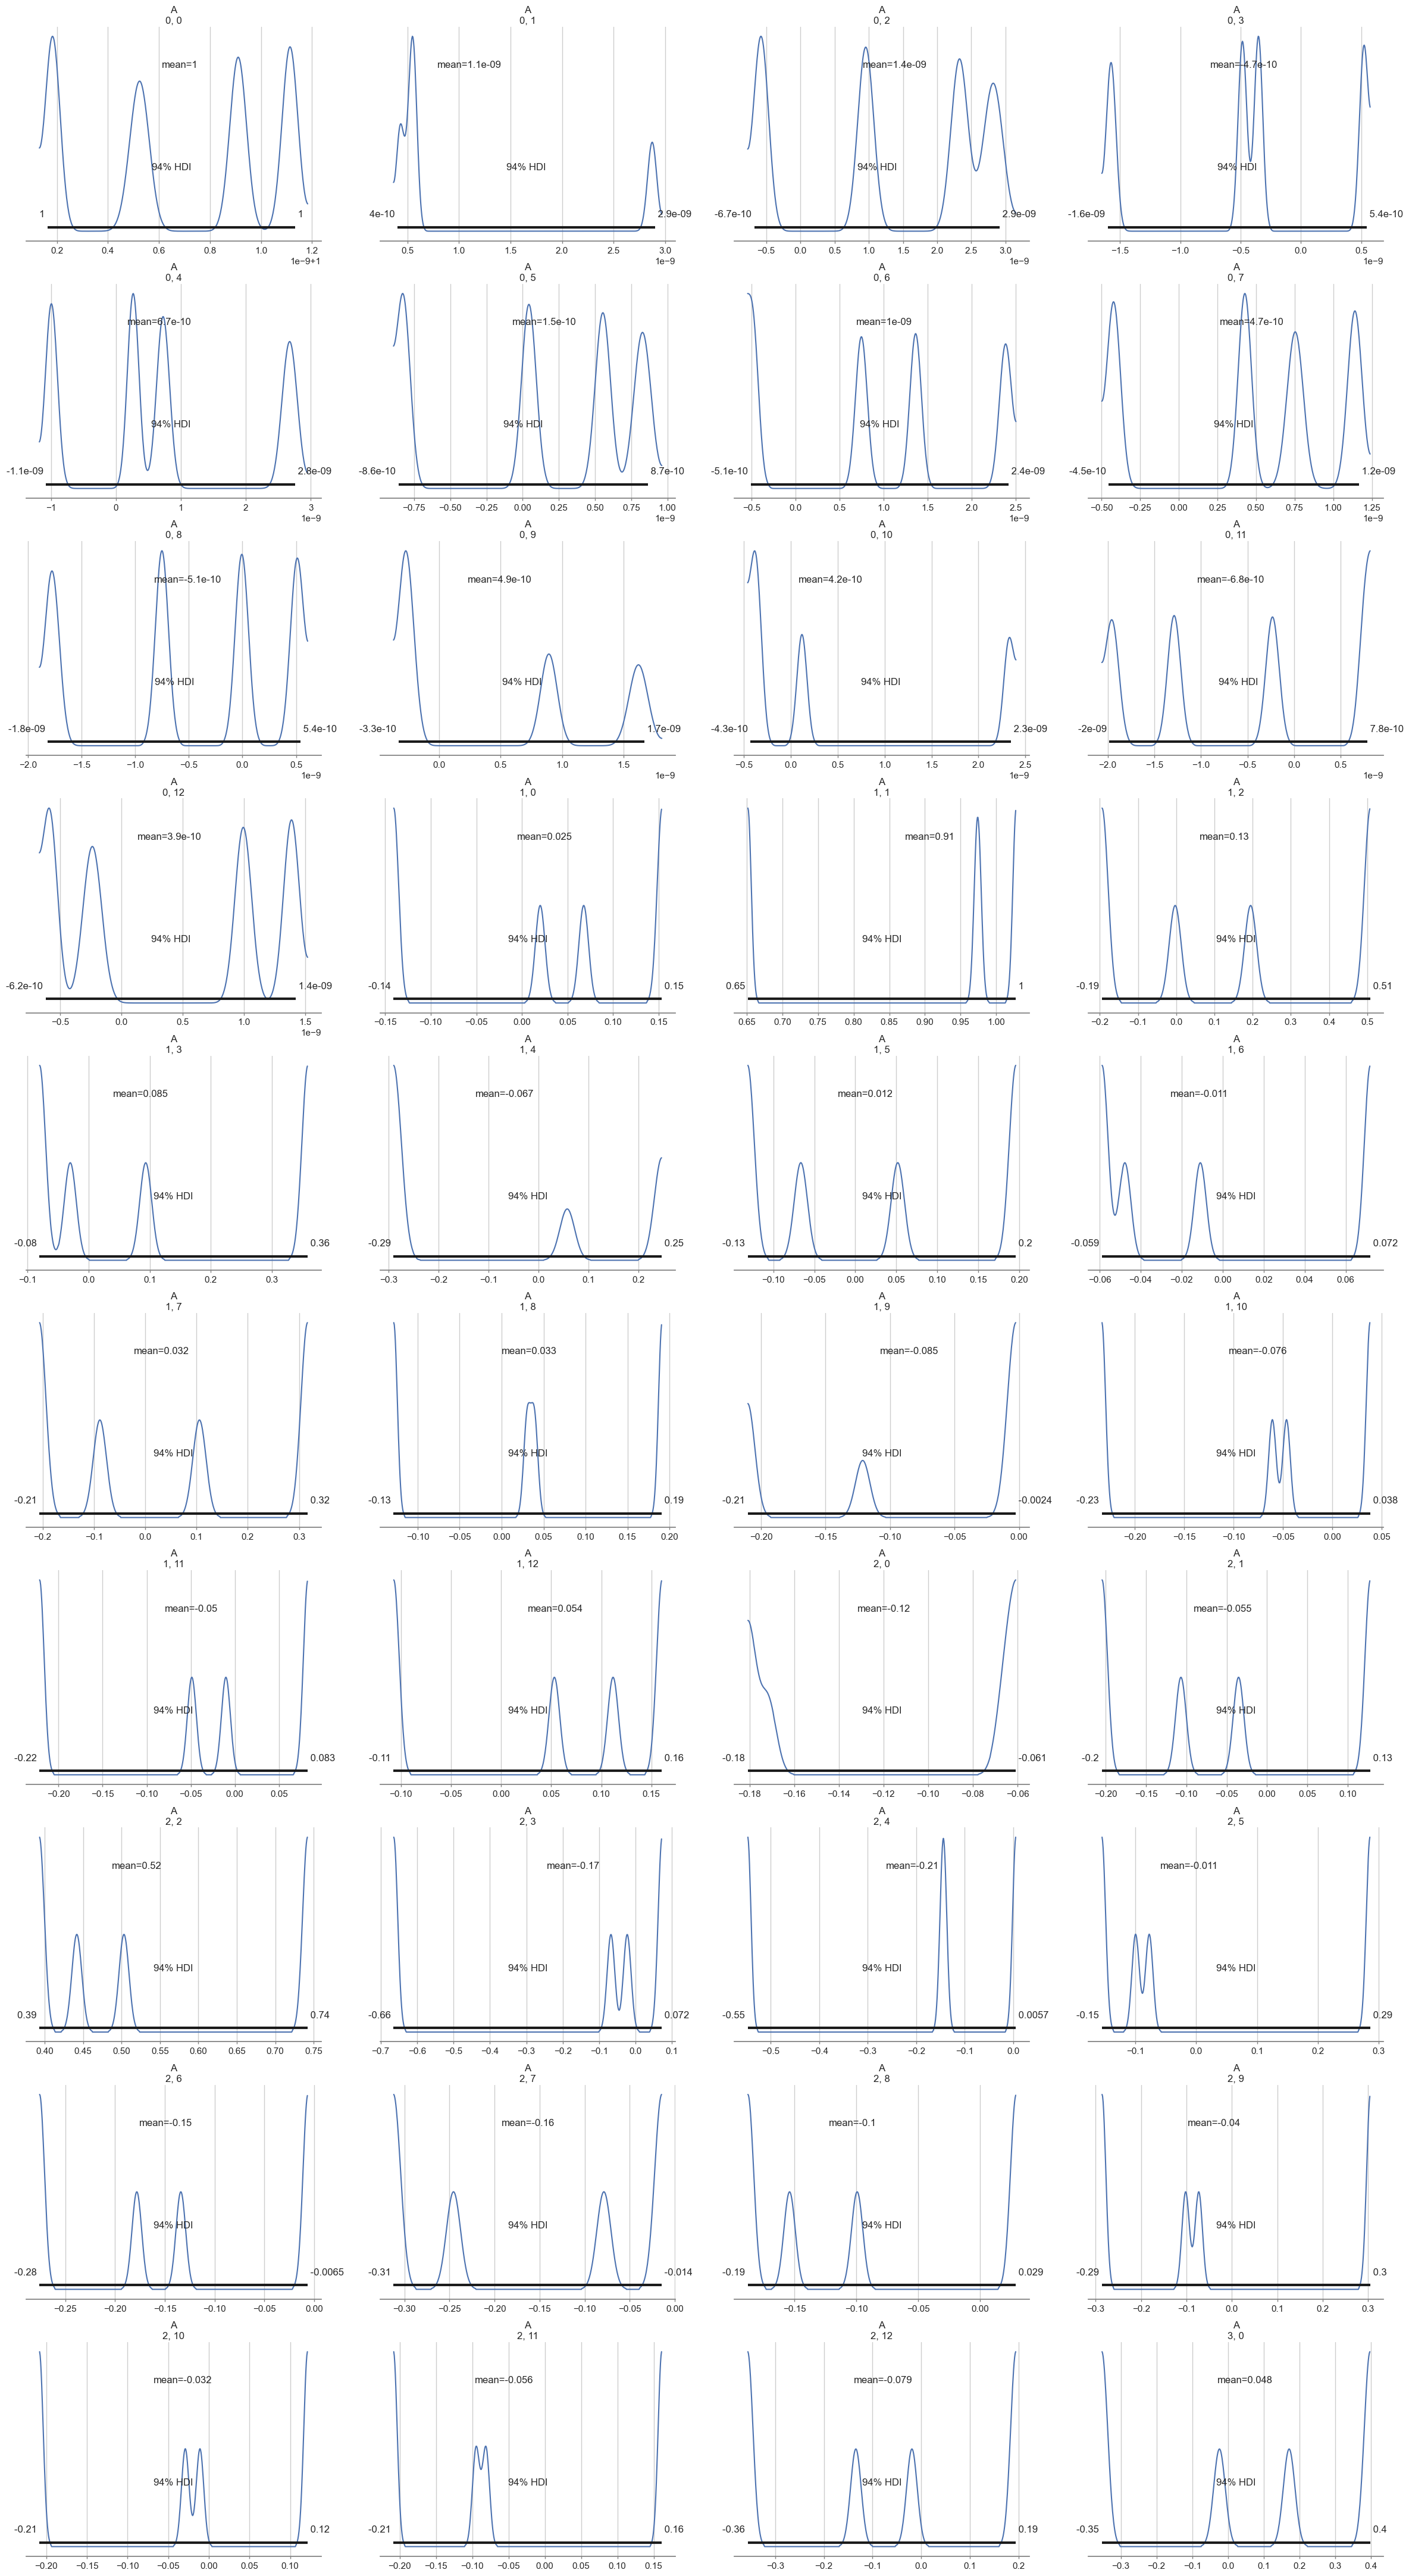

In [20]:
# Standardize data
normalized_data = (imputed_data - np.mean(imputed_data,
                   axis=0)) / np.std(imputed_data, axis=0)

# Initialize and run the model with standardized data
infer3 = infer_VAR(normalized_data)
infer3.run_inference_large()

We are then going to try and reduce the number of variables to infer relationships between. We are going to use the top 3 (most abundant) genus that have the highest abundance in the dataset. 

In [21]:
# try reducing the number of columns to 3 for imputed_data for the most abundant genera

# calculate the mean abundance of each genus

print(imputed_data.mean())

# Get the most abundant genera (pick the top 3)
most_abundant_genera = imputed_data.mean().sort_values(
    ascending=False).head(3).index

print(most_abundant_genera)

# Reduce the number of columns to the most abundant genera
imputed_data_reduced = imputed_data[most_abundant_genera]

days                     204.500000
Acidimicrobium             7.893178
Acinetobacter              9.441983
Albidiferax                5.600342
Candidatus Microthrix     24.973158
Chitinophaga pinensis     11.994440
Dechloromonas              2.267461
Haliscomenobacter          7.822878
Intrasporangium            6.793113
Leptospira                 6.285400
Other                      2.424799
Xanthomonas                2.256361
mean abundance < 2%       12.388322
dtype: float64
Index(['days', 'Candidatus Microthrix', 'mean abundance < 2%'], dtype='object')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 185 seconds.
There were 967 divergences after tuning. Increase `target_accept` or reparameterize.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]  1.001  0.000   1.001    1.001        0.0      0.0    5500.0   
A[0, 1]  0.009  0.001   0.008    0.011        0.0      0.0    9441.0   
A[0, 2]  0.044  0.001   0.042    0.047        0.0      0.0   10888.0   
A[1, 0]  0.000  0.000  -0.000    0.001        0.0      0.0   10791.0   
A[1, 1]  0.997  0.003   0.991    1.003        0.0      0.0    7398.0   
A[1, 2]  0.001  0.005  -0.009    0.010        0.0      0.0    9774.0   
A[2, 0] -0.000  0.000  -0.000    0.000        0.0      0.0    9025.0   
A[2, 1]  0.000  0.001  -0.001    0.002        0.0      0.0    8757.0   
A[2, 2]  1.000  0.002   0.997    1.003        0.0      0.0   11333.0   

         ess_tail  r_hat  
A[0, 0]    7951.0    1.0  
A[0, 1]   10085.0    1.0  
A[0, 2]    9678.0    1.0  
A[1, 0]    9103.0    1.0  
A[1, 1]    9516.0    1.0  
A[1, 2]   10021.0    1.0  
A[2, 0]    9135.0    1.0  
A[2, 1]   10191.0    1.0  
A[2, 2]   10580.0    1.0  


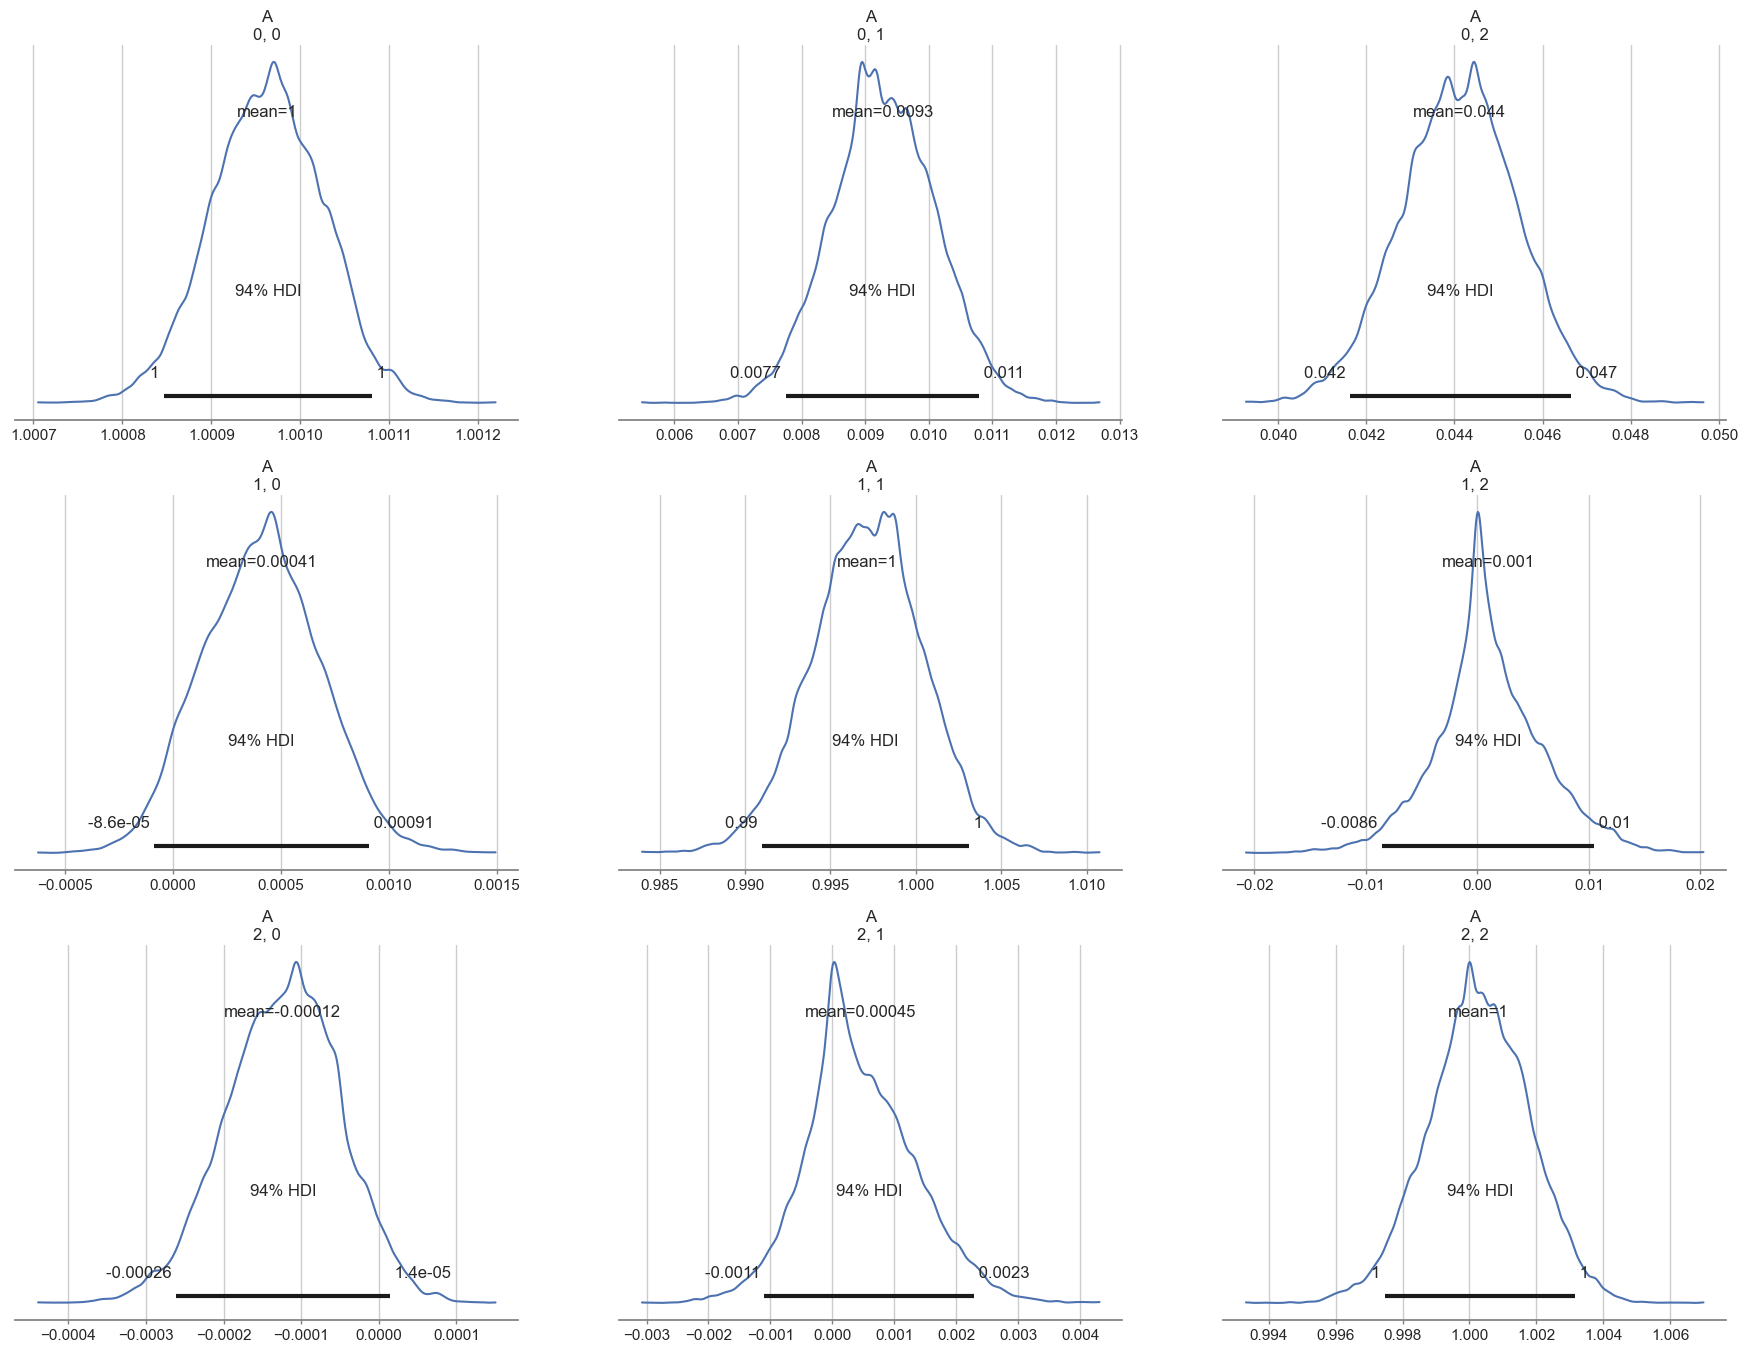

In [22]:
# Now do the inference with only the most abundant genera

infer4 = infer_VAR(imputed_data_reduced)
infer4.run_inference_large()

We can see that the results much better, though we had to reduce the complexity. Therefore, how can we improve the inference results without reducing the complexity of the model? First of all, we are going to try and remove the days column from the dataset. This is because the days column is not a variable, but a time index.

In [23]:
# Do the same, but excluding the 'days' column as a feature

imputed_data_reduced_no_days = imputed_data_reduced.drop(columns='days')

infer5 = infer_VAR(imputed_data_reduced_no_days)
infer5.run_inference_large()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 110 seconds.
There were 478 divergences after tuning. Increase `target_accept` or reparameterize.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]  1.000  0.003   0.995    1.005        0.0      0.0    6443.0   
A[0, 1]  0.001  0.005  -0.009    0.012        0.0      0.0    6066.0   
A[1, 0] -0.000  0.001  -0.002    0.001        0.0      0.0    7214.0   
A[1, 1]  1.000  0.002   0.997    1.003        0.0      0.0    6895.0   

         ess_tail  r_hat  
A[0, 0]    6927.0    1.0  
A[0, 1]    7149.0    1.0  
A[1, 0]    8227.0    1.0  
A[1, 1]    8608.0    1.0  


In [24]:
# try reducing the number of columns to 3 for imputed_data for the most abundant genera

# calculate the mean abundance of each genus

print(imputed_data.mean())

# Get the most abundant genera (pick the top 3)
most_abundant_genera = imputed_data.mean().sort_values(
    ascending=False).head(4).index
most_abundant_genera.drop('days')

print(most_abundant_genera)

# Reduce the number of columns to the most abundant genera
imputed_data_reduced = imputed_data[most_abundant_genera]

days                     204.500000
Acidimicrobium             7.893178
Acinetobacter              9.441983
Albidiferax                5.600342
Candidatus Microthrix     24.973158
Chitinophaga pinensis     11.994440
Dechloromonas              2.267461
Haliscomenobacter          7.822878
Intrasporangium            6.793113
Leptospira                 6.285400
Other                      2.424799
Xanthomonas                2.256361
mean abundance < 2%       12.388322
dtype: float64
Index(['days', 'Candidatus Microthrix', 'mean abundance < 2%',
       'Chitinophaga pinensis'],
      dtype='object')


In [25]:
infer5 = infer_VAR(imputed_data_reduced)
infer5.run_inference_large()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 203 seconds.
There were 1731 divergences after tuning. Increase `target_accept` or reparameterize.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]  1.001  0.000   1.001    1.001        0.0      0.0    3302.0   
A[0, 1]  0.010  0.001   0.008    0.011        0.0      0.0    3026.0   
A[0, 2]  0.045  0.002   0.042    0.049        0.0      0.0    5996.0   
A[0, 3] -0.002  0.002  -0.007    0.002        0.0      0.0    4812.0   
A[1, 0]  0.000  0.000  -0.000    0.001        0.0      0.0    2373.0   
A[1, 1]  0.999  0.004   0.992    1.006        0.0      0.0    6422.0   
A[1, 2]  0.003  0.006  -0.006    0.016        0.0      0.0    3234.0   
A[1, 3] -0.007  0.009  -0.025    0.006        0.0      0.0    3923.0   
A[2, 0] -0.000  0.000  -0.000    0.000        0.0      0.0    4446.0   
A[2, 1]  0.001  0.001  -0.001    0.003        0.0      0.0    3489.0   
A[2, 2]  1.002  0.002   0.998    1.006        0.0      0.0    3718.0   
A[2, 3] -0.002  0.003  -0.008    0.002        0.0      0.0    3148.0   
A[3, 0] -0.000  0.000  -0.000    0.000        0.0      0.0    28

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 1485 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 3733 divergences after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    0.985  0.008   0.969    1.000        0.0      0.0    2461.0   
A[0, 1]    0.004  0.002   0.001    0.007        0.0      0.0    1742.0   
A[0, 2]   -0.024  0.009  -0.041   -0.006        0.0      0.0     898.0   
A[0, 3]    0.001  0.002  -0.003    0.005        0.0      0.0    2060.0   
A[0, 4]    0.007  0.003   0.001    0.013        0.0      0.0    2167.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[11, 7]   0.006  0.004  -0.001    0.013        0.0      0.0    1116.0   
A[11, 8]   0.015  0.003   0.010    0.020        0.0      0.0    3508.0   
A[11, 9]  -0.102  0.019  -0.138   -0.066        0.0      0.0    4823.0   
A[11, 10]  0.003  0.011  -0.017    0.029        0.0      0.0    2548.0   
A[11, 11]  1.009  0.005   0.998    1.019        0.0      0.0    1548.0   

           ess_tail  r_hat  
A[0, 0]      1395.0    1.0  
A[0, 1]      1154.0    1.0  
A[0, 2]      2303.0    1

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (144) in plot_posterior, generating only 40 plots
  warnings.warn(


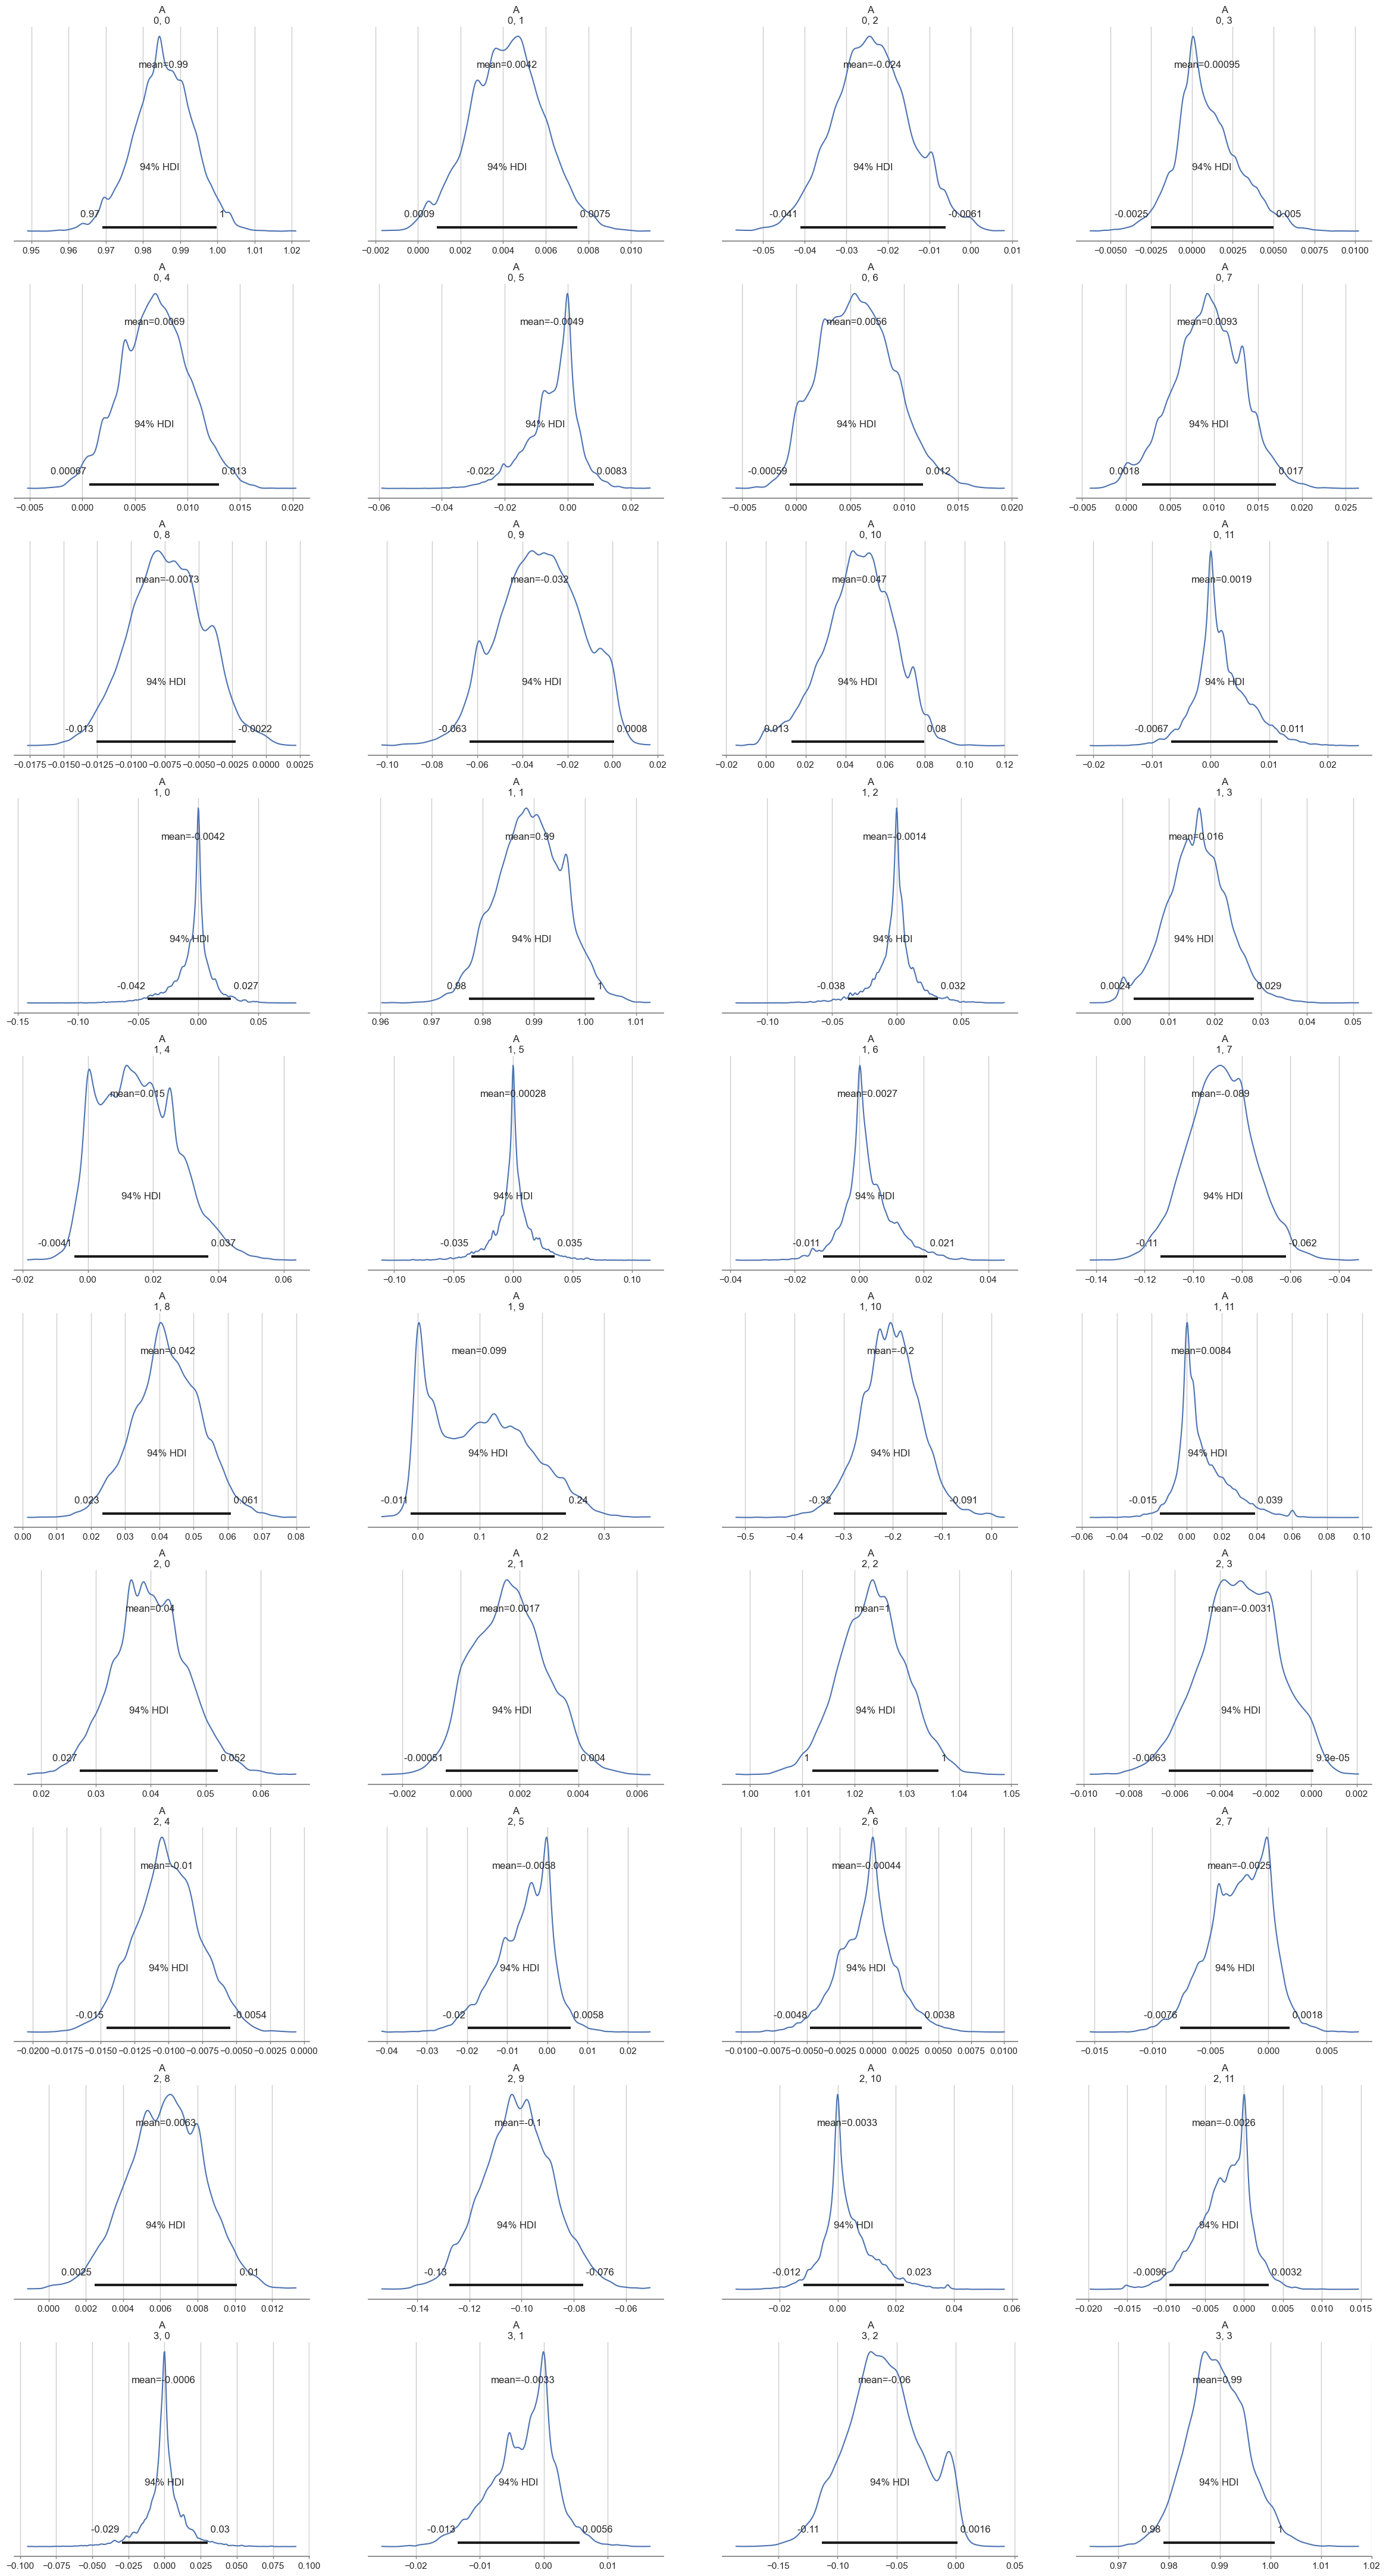

In [26]:
# Do the same, but excluding the 'days' column as a feature from the impuuted data set

imputed_data_reduced_no_days = imputed_data.drop(columns='days')

infer6 = infer_VAR(imputed_data_reduced_no_days)
infer6.run_inference_large()

Not necessarily better, but we can see that the results are different. This is because the days column was removed from the dataset, so the model is now inferring the relationships between the variables without the time as a feature. If time as a feauture affects the results, this means that the data is not stationary. We can try to make the data stationary by differencing the data.


First, we will test to see if the data is stationary or not using the `statsmodels` package. 

In [27]:
# Now we are going to check for stationarity in the data using adf and kpss tests from stasmodels library
# We will use the imputed data set

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)
    # if p-value is less than 0.05, we reject the null hypothesis and say that the data is stationary
    # print if the data is stationary or not
    if dftest[1] <= 0.05:
        print("ADF Test: Data is stationary")
    else:
        print("ADF Test: Data is not stationary")


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output)
    # if p-value is greater than 0.05, we reject the null hypothesis and say that the data is stationary
    # print if the data is stationary or not
    if kpsstest[1] >= 0.05:
        print("KPSS test: Data is stationary")
    else:
        print("KPSS test: Data is not stationary")

In [28]:
# Check for stationarity in the data imputed_dataset (without the 'days' column)
imputed_data_reduced_no_days = imputed_data.drop(columns='days')
for genus in imputed_data_reduced_no_days.columns:
    print(genus)
    adf_test(imputed_data_reduced_no_days[genus])
    kpss_test(imputed_data_reduced_no_days[genus])
    print("\n")

Acidimicrobium
Results of Dickey-Fuller Test:
Test Statistic                  -2.694583
p-value                          0.074980
#Lags Used                      17.000000
Number of Observations Used    392.000000
Critical Value (1%)             -3.447142
Critical Value (5%)             -2.868941
Critical Value (10%)            -2.570713
dtype: float64
ADF Test: Data is not stationary
Results of KPSS Test:
Test Statistic            0.181567
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS test: Data is stationary


Acinetobacter
Results of Dickey-Fuller Test:
Test Statistic                  -1.760882
p-value                          0.400048
#Lags Used                      18.000000
Number of Observations Used    391.000000
Critical Value (1%)             -3.447186
Critical Value (5%)             -2.868960
C

C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside

These tests results show that most of the genus' samples is not stationary, which means that the data is not homoscedastic. This is a common problem in microbiome data, where the variance of the data is not constant across the samples. This is a problem for most imputation methods, as they assume that the data is homoscedastic.

To change this, we will be using a detrending method to make the data stationary by differencing the data. This will allow us to use the VAR inference method to impute the parameters of interaction. 

It is one of the simplest methods for detrending a time series. A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

In [29]:
# Differencing the imputed data set to make it stationary

differenced_data = imputed_data_reduced_no_days.diff().dropna()

# Check for stationarity in the differenced data set

for genus in differenced_data.columns:
    print(genus)
    adf_test(differenced_data[genus])
    kpss_test(differenced_data[genus])
    print("\n")

Acidimicrobium
Results of Dickey-Fuller Test:
Test Statistic                  -4.579203
p-value                          0.000141
#Lags Used                      16.000000
Number of Observations Used    392.000000
Critical Value (1%)             -3.447142
Critical Value (5%)             -2.868941
Critical Value (10%)            -2.570713
dtype: float64
ADF Test: Data is stationary
Results of KPSS Test:
Test Statistic            0.032483
p-value                   0.100000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS test: Data is stationary


Acinetobacter
Results of Dickey-Fuller Test:


C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Test Statistic                  -4.592770
p-value                          0.000133
#Lags Used                      17.000000
Number of Observations Used    391.000000
Critical Value (1%)             -3.447186
Critical Value (5%)             -2.868960
Critical Value (10%)            -2.570723
dtype: float64
ADF Test: Data is stationary
Results of KPSS Test:
Test Statistic            0.174216
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
KPSS test: Data is stationary


Albidiferax
Results of Dickey-Fuller Test:
Test Statistic                  -4.009900
p-value                          0.001360
#Lags Used                      11.000000
Number of Observations Used    397.000000
Critical Value (1%)             -3.446930
Critical Value (5%)             -2.868848
Critical Value (10%)            -2.570663
dtype: floa

C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\User\AppData\Local\Temp\ipykernel_27368\3039934652.py:33: InterpolationWarning: The test statistic is outside

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A, noise_chol]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 1592 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 6249 divergences after tuning. Increase `target_accept` or reparameterize.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    0.927  0.019   0.891    0.965      0.001    0.000     890.0   
A[0, 1]    0.001  0.003  -0.005    0.008      0.000    0.000    2333.0   
A[0, 2]   -0.059  0.025  -0.102   -0.021      0.006    0.005      15.0   
A[0, 3]    0.007  0.005  -0.003    0.016      0.000    0.000    1355.0   
A[0, 4]    0.009  0.009  -0.004    0.026      0.001    0.001      64.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[11, 7]   0.007  0.017  -0.023    0.045      0.001    0.001      88.0   
A[11, 8]  -0.000  0.015  -0.023    0.030      0.005    0.004      10.0   
A[11, 9]   0.177  0.115  -0.015    0.373      0.020    0.014      49.0   
A[11, 10]  0.022  0.045  -0.057    0.119      0.001    0.001     208.0   
A[11, 11]  0.853  0.032   0.792    0.907      0.006    0.004      33.0   

           ess_tail  r_hat  
A[0, 0]      4519.0   1.05  
A[0, 1]      3923.0   1.12  
A[0, 2]       106.0   1.

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (144) in plot_posterior, generating only 40 plots
  warnings.warn(


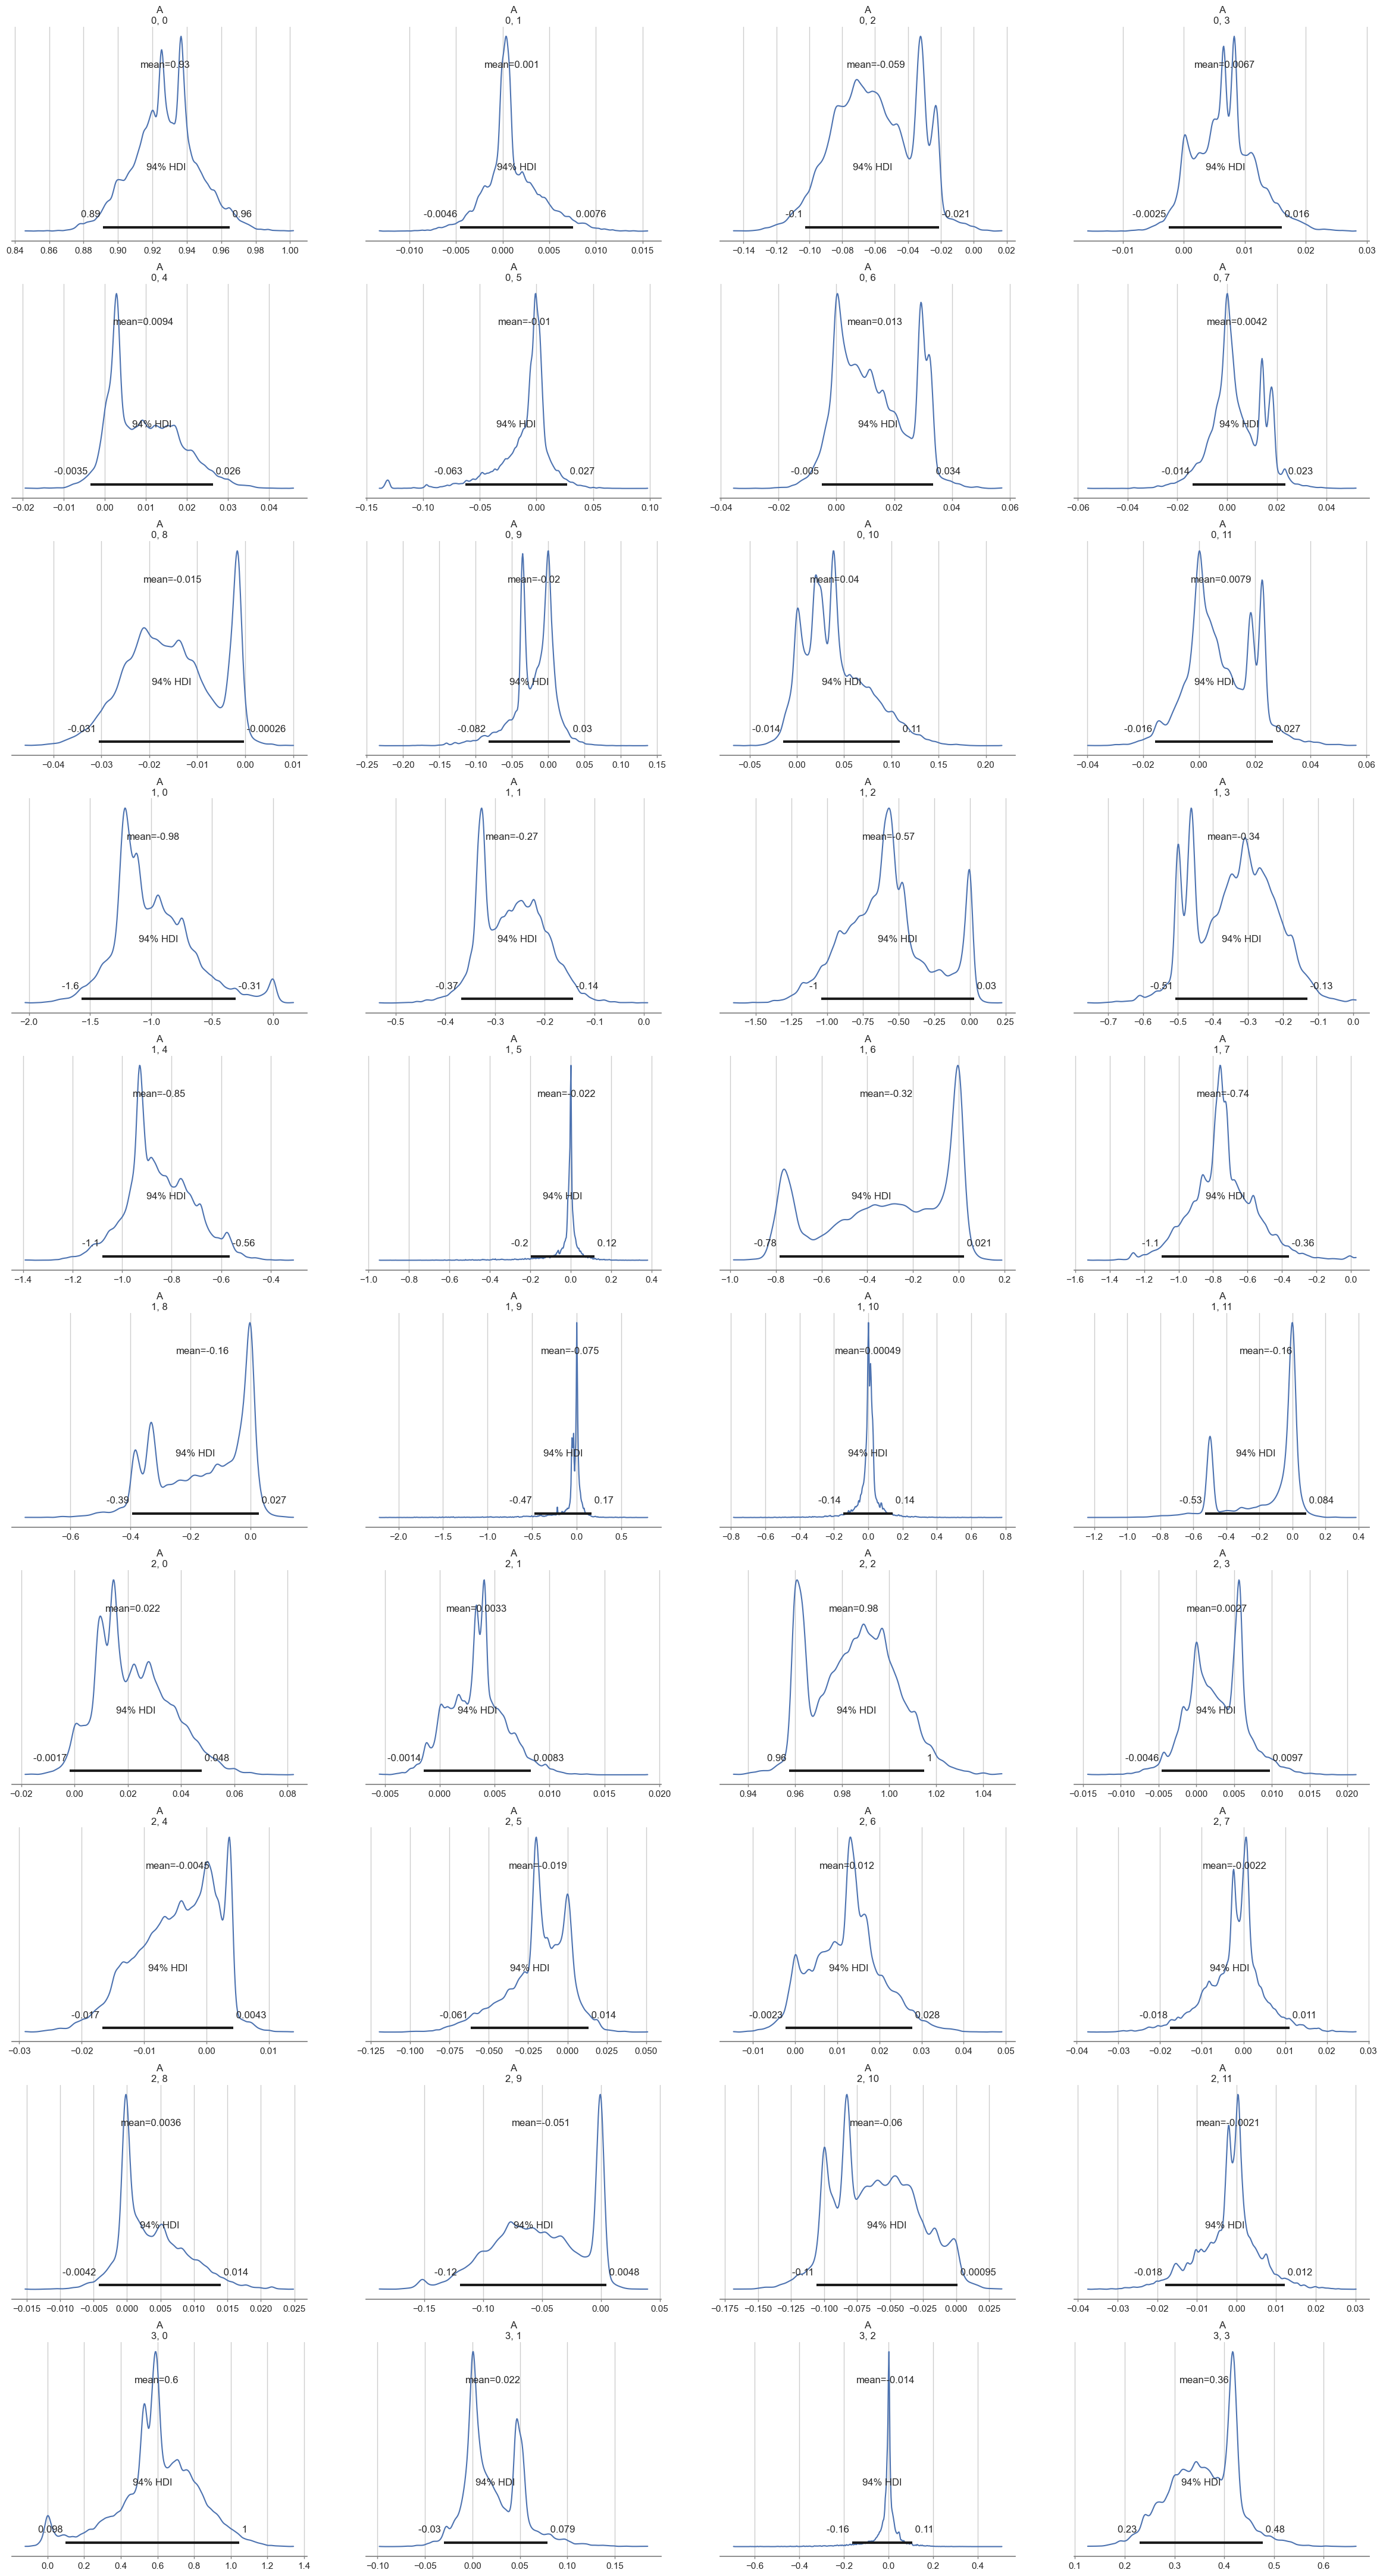

In [30]:
# Now we are going to to the VAR inference with the differenced data set

infer7 = infer_VAR(differenced_data)
infer7.run_inference_large()

We can see the results of inferring the differenciated data. The results are not much better than before. So now, we are going to try one last method to improve the inference results. We are going use `statsmodels` to infer the relationships between the variables in the time series using a VAR model, then use the predicted posterior distributions as priors for the inference method and observe the results.

In [31]:
from statsmodels.tsa.api import VAR

In [32]:
# create a pandas dataframe of the original imputed data_set with days as the index
imputed_data.set_index('days', inplace=True)

In [33]:
# make VAR model with the imputed data set and statsmodels library
model = VAR(imputed_data)
results = model.fit(maxlags=1, method='ml')

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [34]:
coefficients = results.params
covariance_matrix = results.sigma_u
intercepts = np.array(results.params.iloc[0])

# remove the first row of the coefficients matrix
coefficients = coefficients[1:]
# transpose the coefficients matrix
coefficients = coefficients.T

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x0, A]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1179 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x0[0]      1.016  0.495   0.156    2.012      0.011    0.008    2104.0   
x0[1]      7.663  0.903   6.024    9.347      0.014    0.010    3884.0   
x0[2]      0.647  0.423  -0.160    1.430      0.010    0.007    1878.0   
x0[3]      4.886  0.901   3.112    6.504      0.015    0.011    3458.0   
x0[4]      4.070  0.736   2.747    5.486      0.014    0.010    2763.0   
...          ...    ...     ...      ...        ...      ...       ...   
A[11, 7]   0.020  0.007   0.008    0.034      0.000    0.000    2517.0   
A[11, 8]   0.027  0.006   0.015    0.038      0.000    0.000    2289.0   
A[11, 9]  -0.100  0.023  -0.144   -0.058      0.000    0.000    4257.0   
A[11, 10]  0.020  0.021  -0.020    0.059      0.000    0.000    4652.0   
A[11, 11]  1.020  0.010   1.001    1.038      0.000    0.000    2882.0   

           ess_tail  r_hat  
x0[0]        2729.0    1.0  
x0[1]        3114.0    1.0  
x0[2]        2220.0    1

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (156) in plot_posterior, generating only 40 plots
  warnings.warn(


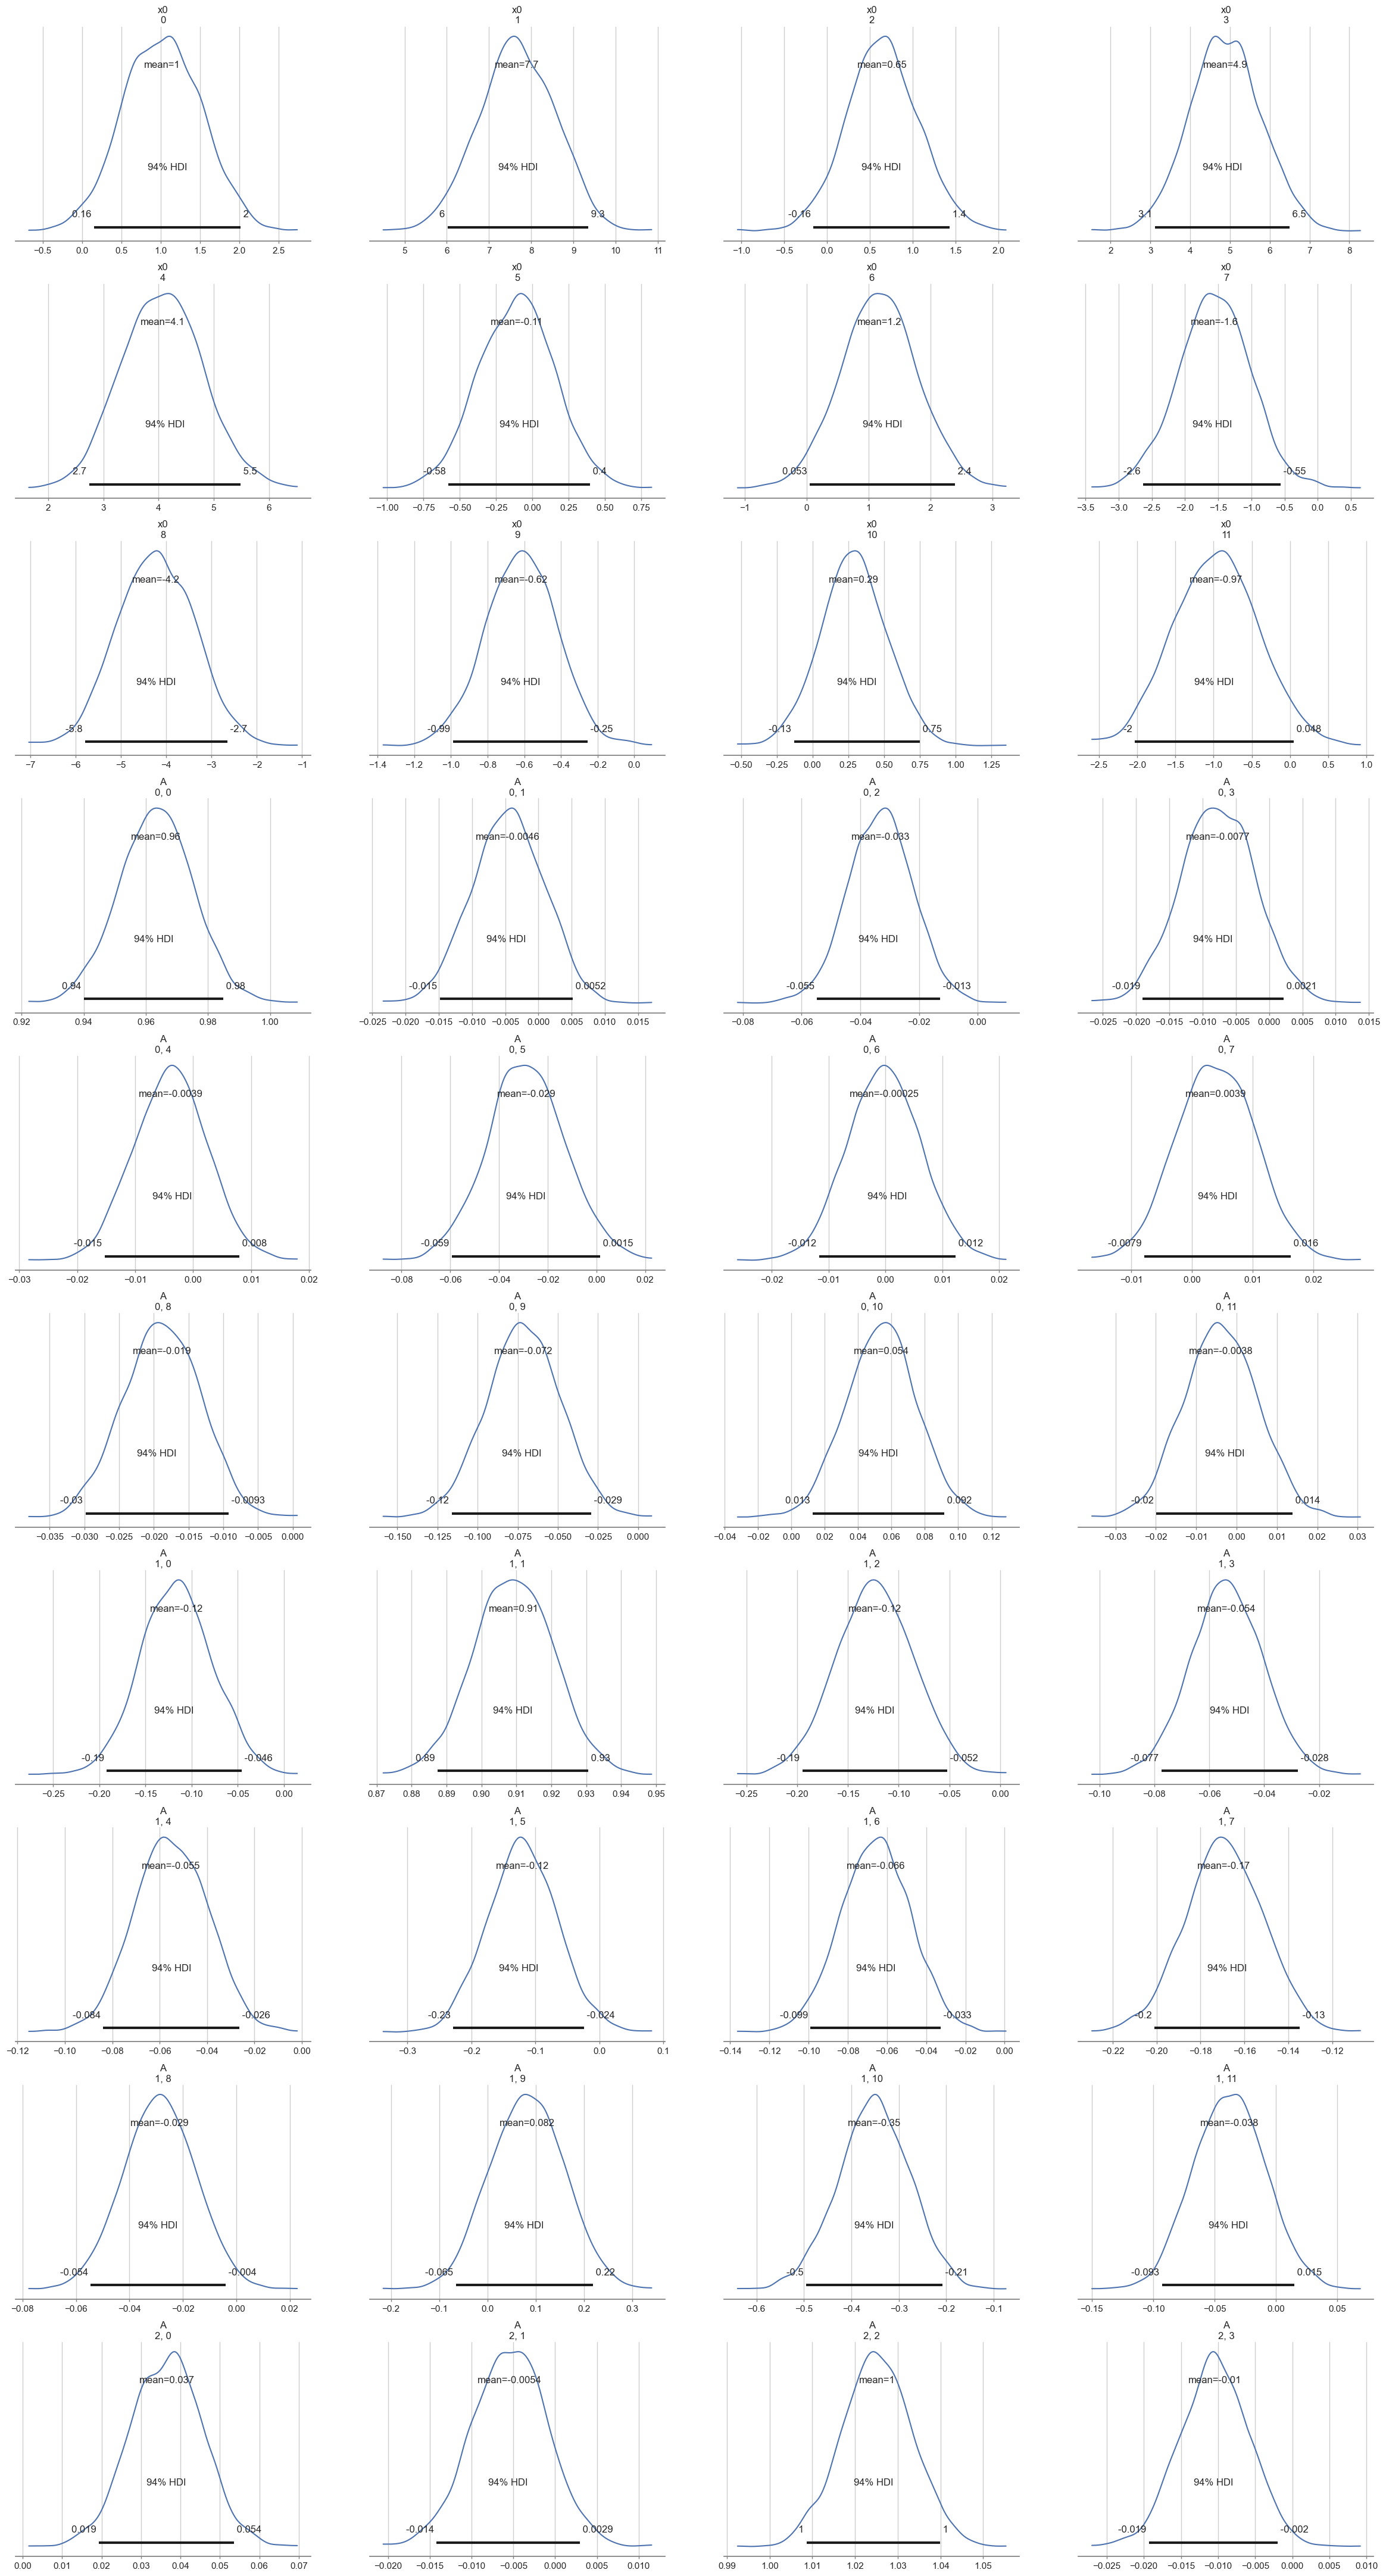

In [35]:
# now use the VAR model with these as priors
infer8 = infer_VAR(imputed_data, coefficients, intercepts, covariance_matrix)
infer8.run_inference()

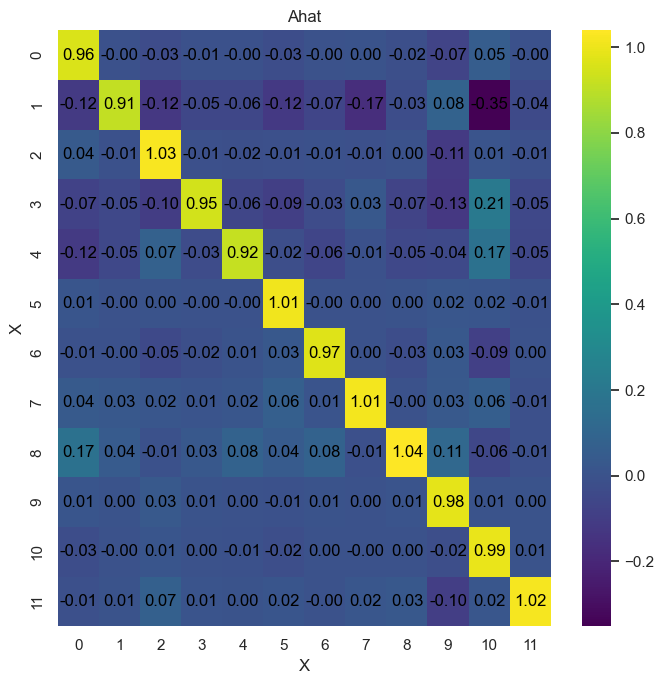

In [36]:
posterior = az.from_netcdf('model_posterior.nc')
infer8.plot_heatmap(idata=posterior, matrices=['A'])

As we can see, the results are much better than before. This is because bayesian VAR inference method works much better with the predicted posterior distributions as priors. This is because the predicted posterior distributions offer a better estimate of the parameters of interaction between the variables in the time series which the bayesian VAR inference method can use to infer the causal relationships between the variables in the time series.

In [37]:
# do the same for run_inference_large
infer9 = infer_VAR(imputed_data, coefficients, intercepts, covariance_matrix)
infer9.run_inference_large()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_stddev, x0, c2, tau, lam, A]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 5973 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3408 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


            mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A[0, 0]    0.963  0.0   0.963    0.963        0.0      0.0      89.0   
A[0, 1]   -0.005  0.0  -0.005   -0.005        0.0      0.0     503.0   
A[0, 2]   -0.033  0.0  -0.033   -0.033        0.0      0.0     125.0   
A[0, 3]   -0.008  0.0  -0.008   -0.008        0.0      0.0     236.0   
A[0, 4]   -0.004  0.0  -0.004   -0.004        0.0      0.0     935.0   
...          ...  ...     ...      ...        ...      ...       ...   
A[11, 7]   0.020  0.0   0.020    0.020        0.0      0.0     700.0   
A[11, 8]   0.027  0.0   0.027    0.027        0.0      0.0     938.0   
A[11, 9]  -0.101  0.0  -0.101   -0.101        0.0      0.0     599.0   
A[11, 10]  0.020  0.0   0.020    0.020        0.0      0.0     718.0   
A[11, 11]  1.020  0.0   1.020    1.020        0.0      0.0     394.0   

           ess_tail  r_hat  
A[0, 0]        13.0   1.14  
A[0, 1]       254.0   1.05  
A[0, 2]        26.0   1.06  
A[0, 3]        79.0

c:\ProgramData\anaconda3\envs\MIMIC\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (144) in plot_posterior, generating only 40 plots
  warnings.warn(


OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [ ]:
posterior2 = az.from_netcdf('model_posterior.nc')
infer9.plot_heatmap(idata=posterior2, matrices=['A'])